In [1]:
# import tensorflow as tf
# tf.__version__

In [12]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import pandas as pd
import numpy as np
import tqdm, datetime, pickle
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import ngboost as ngb

from sklearn import datasets

import plotnine
from plotnine import *

import seaborn as sns

import matplotlib.pyplot as plt

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten

In [6]:
float(format(0.0002456, '.2g')) 

0.00025

# 预处理数据，简单预处理而已

## 重新处理数据

In [34]:
data_train = pd.read_csv("originalDataset/train.csv")
data_train.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
0,0,35000.0,5,19.52,917.97,E,E2,320.0,2 years,2,...,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0
1,1,18000.0,5,18.49,461.90,D,D2,219843.0,5 years,0,...,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN
2,2,12000.0,5,16.99,298.17,D,D3,31698.0,8 years,0,...,0.0,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0
3,3,11000.0,3,7.26,340.96,A,A4,46854.0,10+ years,1,...,16.0,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0
4,4,3000.0,3,12.99,101.07,C,C2,54.0,NaN,1,...,4.0,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0


In [35]:
total_list = sorted(list(data_train.columns))
numerical_category_fewValues = [
    "homeOwnership", 
    "verificationStatus",
    "initialListStatus",
    "applicationType",
    "n11",
    "n12",
]
numerical_category_manyValues = [
    "regionCode",
    "employmentTitle",
    "purpose",
    "postCode",
    "title",
]
date_type = [
    "issueDate", 
    "earliesCreditLine"
]
numerical_serial = [
    "loanAmnt","interestRate","installment","annualIncome","dti","delinquency_2years","ficoRangeLow","ficoRangeHigh","openAcc",
    "pubRec","pubRecBankruptcies","revolBal","revolUtil","totalAcc","n0","n1","n2","n3",
    "n4","n5","n6","n7","n8","n9","n10","n13","n14",
    "term", 
]
object_serial = [
    "grade",
    "subGrade", 
    "employmentLength"
]
new_cates = numerical_category_fewValues + numerical_category_manyValues + date_type + numerical_serial + object_serial
set(total_list) - set(new_cates)

{'id', 'isDefault', 'policyCode'}

In [36]:
for col in tqdm.tqdm(['subGrade', 'grade']): #, 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))

100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s]


In [37]:
#转化成时间格式
for data in [data_train]:
    # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    # #构造时间特征
    data['issueYear'] = data['issueDate'].apply(lambda x: int(x.split("-")[0]))
    data['issueMonth'] = data['issueDate'].apply(lambda x: int(x.split("-")[1]))
    
#转化成时间格式
def monthMapping(monthStr):
    dic = {
        "Jan": 1, 
        "Feb": 2, 
        "Mar": 3,
        "Apr": 4,
        "May": 5, 
        "Jun": 6, 
        "Jul": 7, 
        "Aug": 8, 
        "Sep": 9,
        "Oct": 10, 
        "Nov": 11,
        "Dec": 12
    }
    return dic[monthStr]

for data in [data_train]:
    # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    # #构造时间特征
    data['earliesCreditLineYear'] = data['earliesCreditLine'].apply(lambda x: int(x.split("-")[1]))
    data['earliesCreditLineMonth'] = data['earliesCreditLine'].apply(lambda x: monthMapping(x.split("-")[0]))
    
#转化成时间格式
startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days
    
startmonth = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
for data in [data_train]:
    data["earliesCreditLine"] = data["earliesCreditLine"].apply(lambda x: datetime.datetime.strptime(x, '%b-%Y'))
    data["earliesCreditLineDT"] = data["earliesCreditLine"].apply(lambda x: x-startdate).dt.days
    
date_type += [
    "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
    "issueYear", "issueMonth"
]
date_type

['issueDate',
 'earliesCreditLine',
 'issueDateDT',
 'earliesCreditLineDT',
 'earliesCreditLineYear',
 'earliesCreditLineMonth',
 'issueYear',
 'issueMonth']

In [38]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0]) ## mind this. use the int type in np, not general python int. 
    
for data in [data_train,]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [39]:
data_train.shape

(800000, 53)

In [57]:
for fea in numerical_serial:
    #按照平均数填充数值型特征
    data_train[fea] = data_train[fea].fillna(data_train[fea].median())
for fea in numerical_category_fewValues + numerical_category_manyValues + object_serial + date_type:
    #按照众数填充类别型特征
    data_train[fea] = data_train[fea].fillna(data_train[fea].mode())

In [58]:
data_train.fillna(method="ffill", inplace=True) ## 最后的缺失值，只好拿固定的数字去填充了。
print(np.isnan(data_train).any())

id                        False
loanAmnt                  False
term                      False
interestRate              False
installment               False
grade                     False
subGrade                  False
employmentTitle           False
employmentLength          False
homeOwnership             False
annualIncome              False
verificationStatus        False
issueDate                 False
isDefault                 False
purpose                   False
postCode                  False
regionCode                False
dti                       False
delinquency_2years        False
ficoRangeLow              False
ficoRangeHigh             False
openAcc                   False
pubRec                    False
pubRecBankruptcies        False
revolBal                  False
revolUtil                 False
totalAcc                  False
initialListStatus         False
applicationType           False
earliesCreditLine         False
title                     False
policyCo

In [59]:
data_train.to_csv("preprocessedDataset/pre1.csv", index=False)

In [60]:
data_train["n12"].value_counts()

0.0    797482
1.0      2382
2.0       117
3.0        16
4.0         3
Name: n12, dtype: int64

## 加载处理好的数据

In [2]:
data_train = pd.read_csv("preprocessedDataset/pre1.csv")
numerical_category_fewValues = [
    "homeOwnership", 
    "verificationStatus",
    "initialListStatus",
    "applicationType",
    "n11",
    "n12",
]
numerical_category_manyValues = [
    "regionCode",
    "employmentTitle",
    "purpose",
    "postCode",
    "title",
]
date_type = [
    'issueDate',
    'earliesCreditLine',
    'issueDateDT',
    'earliesCreditLineDT',
    'earliesCreditLineYear',
    'earliesCreditLineMonth',
    'issueYear',
    'issueMonth'
]
numerical_serial = [
    "loanAmnt","interestRate","installment","annualIncome","dti","delinquency_2years","ficoRangeLow","ficoRangeHigh","openAcc",
    "pubRec","pubRecBankruptcies","revolBal","revolUtil","totalAcc","n0","n1","n2","n3",
    "n4","n5","n6","n7","n8","n9","n10","n13","n14",
    "term", 
]
object_serial = [
    "grade",
    "subGrade", 
    "employmentLength"
]

# 来搞模型

我们拿xgb，lgb，cat来模拟若干个模型；然后拿lr来模拟策略模型。

## 数据切分

In [3]:
data_train.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       'annualIncome', 'verificationStatus', 'issueDate', 'isDefault',
       'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years',
       'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec',
       'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc',
       'initialListStatus', 'applicationType', 'earliesCreditLine', 'title',
       'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8',
       'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'issueYear', 'issueMonth',
       'earliesCreditLineYear', 'earliesCreditLineMonth', 'issueDateDT',
       'earliesCreditLineDT'],
      dtype='object')

In [4]:
features = [f for f in data_train.columns if f not in ['id', 'isDefault', "policyCode", "issueDate", "earliesCreditLine"] and '_outliers' not in f]
y_full = data_train['isDefault']
x_full = data_train[features]

In [5]:
from sklearn.model_selection import train_test_split

X_, X_test, y_, y_test = train_test_split(x_full, y_full, test_size=0.5, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.6, random_state=0)
del X_, y_

## XGB

In [6]:
def train_xgb():
    params={
            'booster':'gbtree',
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 5,
            'scale_pos_weight': 3,
            'learning_rate': 0.1, 
            'reg_lambda': 5,
            'reg_alpha': 0, 
            'colsample_bytree': 0.8,
        }
    dtrain = xgb.DMatrix(X_train.to_numpy(), label=y_train.to_numpy())
    dtest = xgb.DMatrix(X_valid.to_numpy(), label=y_valid.to_numpy())
    model = xgb.train(params, dtrain, num_boost_round=10000, evals=[(dtrain, 'train'), (dtest, 'test')],
                                                  early_stopping_rounds=50,verbose_eval=200)
    
    return model

xgb_model = train_xgb()

[0]	train-auc:0.70064	test-auc:0.70002
[200]	train-auc:0.76731	test-auc:0.72954
[300]	train-auc:0.78250	test-auc:0.72956


In [7]:
xgb_model.save_model("trainedModel/xgb.json")

## LightGBM

In [8]:
def train_lgb():
    
    categorical_fea_index = []
    for i, col in enumerate(X_train.columns):
        if col in numerical_category_fewValues + numerical_category_manyValues + object_serial:
            categorical_fea_index.append(i)
    categorical_fea_index
    
    dtrain = lgb.Dataset(X_train.to_numpy(), label=y_train.to_numpy())
    dtest = lgb.Dataset(X_valid.to_numpy(), label=y_valid.to_numpy())

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'min_child_weight': 5,
        'num_leaves': 16,
        'lambda_l2': 10,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 4,
        'learning_rate': 0.1,
        'seed': 2020,
        'nthread': 28,
        'n_jobs':24,
        'silent': True,
        'verbose': -1,    
        # 'device_type': 'gpu',
        'max_bin': 63,

        "categorical_feature": categorical_fea_index
    }

    model = lgb.train(params, dtrain, 10000, valid_sets=[dtrain, dtest], verbose_eval=50, early_stopping_rounds=200)
    
    return model
lgb_model = train_lgb()

NameError: name 'numerical_category_fewValues' is not defined

In [73]:
lgb_model.save_model("trainedModel/lgb.json")

## CatBoost

In [74]:
def train_cat():
    categorical_fea_index = []
    for i, col in enumerate(X_train.columns):
        if col in numerical_category_fewValues + numerical_category_manyValues + object_serial:
            categorical_fea_index.append(i)
    categorical_fea_index
    
    params = {'learning_rate': 0.1, # 0.1, 
              'depth': 7, # 7, # 10, 
              'l2_leaf_reg': 100, #10, #50, 
              'bootstrap_type': 'Bernoulli', 
              'od_type': 'Iter', 
              'od_wait': 300, #50, #300, 
              ### 
              'random_seed': 11, 
              'allow_writing_files': False, 
              # "task_type": "GPU", 
              "eval_metric": "AUC",
              # ### 
              # "subsample": 0.7, "grow_policy": "Depthwise", 
              "min_data_in_leaf": 50, 
              # "one_hot_max_size": 255, 
              # "auto_class_weights": "SqrtBalanced", 
              # "feature_border_type": "MinEntropy", 

              # "fold_permutation_block": 2, 
              # "allow_const_label": True, 
    }
    model = CatBoostClassifier(iterations=20000, **params)
    model.fit(
        X_train, y_train, 
        eval_set=(X_valid, y_valid),
        # cat_features = [], # categorical_fea_index, # numerical_category_fewValues + numerical_category_manyValues + object_serial, 
        use_best_model=True, 
        verbose=100
    )
    return model
cat_model = train_cat()

0:	test: 0.6860173	best: 0.6860173 (0)	total: 98.6ms	remaining: 32m 51s
100:	test: 0.7274568	best: 0.7274568 (100)	total: 2.68s	remaining: 8m 47s
200:	test: 0.7301707	best: 0.7301975 (198)	total: 5.26s	remaining: 8m 38s
300:	test: 0.7309743	best: 0.7309913 (293)	total: 7.85s	remaining: 8m 33s
400:	test: 0.7311380	best: 0.7312278 (359)	total: 10.4s	remaining: 8m 27s
500:	test: 0.7311033	best: 0.7312278 (359)	total: 12.9s	remaining: 8m 23s
600:	test: 0.7310848	best: 0.7312278 (359)	total: 15.5s	remaining: 8m 19s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7312277706
bestIteration = 359

Shrink model to first 360 iterations.


In [75]:
cat_model.save_model("trainedModel/cat.json")

## NGBoost

training, inferencing都很慢。

In [80]:
ngb_model = ngb.NGBRegressor(
    n_estimators=200, verbose_eval=10
).fit(X_train.values, y_train.values)

[iter 0] loss=0.5006 val_loss=0.0000 scale=2.0000 norm=1.3626
[iter 10] loss=0.4758 val_loss=0.0000 scale=2.0000 norm=1.3260
[iter 20] loss=0.4584 val_loss=0.0000 scale=2.0000 norm=1.3089
[iter 30] loss=0.4453 val_loss=0.0000 scale=2.0000 norm=1.3026
[iter 40] loss=0.4351 val_loss=0.0000 scale=2.0000 norm=1.3024
[iter 50] loss=0.4270 val_loss=0.0000 scale=2.0000 norm=1.3059
[iter 60] loss=0.4203 val_loss=0.0000 scale=2.0000 norm=1.3110
[iter 70] loss=0.4146 val_loss=0.0000 scale=2.0000 norm=1.3168
[iter 80] loss=0.4099 val_loss=0.0000 scale=2.0000 norm=1.3228
[iter 90] loss=0.4058 val_loss=0.0000 scale=2.0000 norm=1.3288
[iter 100] loss=0.4023 val_loss=0.0000 scale=2.0000 norm=1.3349
[iter 110] loss=0.3993 val_loss=0.0000 scale=2.0000 norm=1.3404
[iter 120] loss=0.3966 val_loss=0.0000 scale=2.0000 norm=1.3456
[iter 130] loss=0.3942 val_loss=0.0000 scale=2.0000 norm=1.3501
[iter 140] loss=0.3921 val_loss=0.0000 scale=2.0000 norm=1.3540
[iter 150] loss=0.3903 val_loss=0.0000 scale=2.0000

In [81]:
with open('trainedModel/ngb.p', 'wb') as f: ## ngb模型文件的后缀，得是.p，卧槽。
    pickle.dump(ngb_model, f)

## DNN

In [31]:
def train_nn():
    ## https://www.cnblogs.com/motoharu/p/15084770.html
    x_tensor = torch.Tensor(
        StandardScaler().fit_transform(X_train)
    )
    y_tensor = torch.Tensor(y_train.values)

    # https://www.liuyixiang.com/post/115163.html
    ## 这是一个简单的全连接神经网络
    model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1],32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 1),
        torch.nn.Sigmoid()
    )
    criterion = torch.nn.BCELoss(size_average = False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    for epoch in range(500):
        ## 推断
        y_pred = model(x_tensor)
        ## 计算loss
        loss = criterion(y_pred.squeeze(), y_tensor)
        if not (epoch % 50): 
            print(y_pred[:, 0].sum(), epoch, loss)
        ##清空梯度数据
        optimizer.zero_grad()
        ##反向传播，有人说是计算梯度
        loss.backward()
        ##更新权值
        optimizer.step() 
        
    return model

nn_model = train_nn()

/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(76554.1719, grad_fn=<SumBackward0>) 0 tensor(106978.9062, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(30925.9023, grad_fn=<SumBackward0>) 50 tensor(72016.3203, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31783.2500, grad_fn=<SumBackward0>) 100 tensor(71048.0703, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31760.3184, grad_fn=<SumBackward0>) 150 tensor(70582.1250, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31796.1406, grad_fn=<SumBackward0>) 200 tensor(70236.3594, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31970.7832, grad_fn=<SumBackward0>) 250 tensor(70000.2734, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31685.1250, grad_fn=<SumBackward0>) 300 tensor(69815.7188, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(30340.5664, grad_fn=<SumBackward0>) 350 tensor(69721.1094, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(31474.5586, grad_fn=<SumBackward0>) 400 tensor(69582.0312, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(32173.4141, grad_fn=<SumBackward0>) 450 tensor(694

In [32]:
torch.save(nn_model, "trainedModel/nn_model.pt")

## RandomForest

In [92]:
def train_rf():
    model = RandomForestClassifier(n_estimators=200, n_jobs=4)
    model.fit(
        X_train, y_train
    )
    return model
rf_model = train_rf()

In [94]:
with open('trainedModel/rf.pickle', 'wb') as f:
    pickle.dump(rf_model, f)

## ~~SVM~~

太慢了，太久了。

效果很差。

In [72]:
def train_svm():
    scaler = StandardScaler()
    model = SVC(max_iter = 200, probability=True)
    model.fit(
        scaler.fit_transform(X_train), y_train
    )
    return model
svm_model = train_svm()

/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [73]:
with open('svm.pickle', 'wb') as f:
    pickle.dump(svm_model, f)

## ~~KNN~~

inference太慢了

In [36]:
def train_knn():
    scaler = StandardScaler()
    model = KNeighborsClassifier()
    model.fit(
        scaler.fit_transform(X_train), y_train
    )
    return model
knn_model = train_knn()

In [ ]:
with open('knn.pickle', 'wb') as f:
    pickle.dump(knn_model, f)

In [37]:
knn_model.predict_proba(
    StandardScaler().fit_transform(X_test)[:10, :]
)[:, 1]

array([0. , 0.4, 0.2, 0. , 0. , 0. , 0.2, 0.4, 0.4, 0.2])

## ~~DeepFM~~

代码参考 https://github.com/KaydenCheung/Deep-Learning/tree/main/RS/DeepFM

大概能看懂，感觉也不算太复杂，就是费操作，算了，以后有空再弄吧。

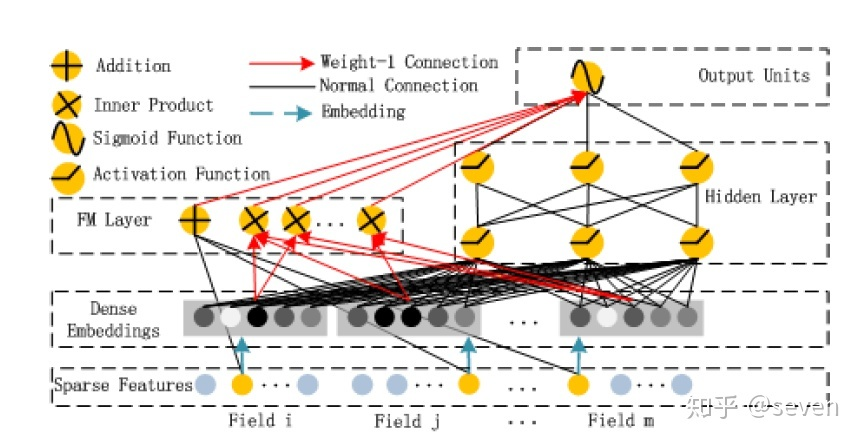

## LR

模拟策略模型

In [10]:
def train_lr():
    scaler = StandardScaler()
    model = LogisticRegression(max_iter=200)
    model.fit(
        scaler.fit_transform(X_train), y_train
    )
    return model
lr_model = train_lr()

In [71]:
with open('trainedModel/lr.pickle', 'wb') as f:
    pickle.dump(lr_model, f)

# 与策略交叉

* 在预测集上预测一下。
* 预测出来的评分进行交叉。

In [6]:
xgb_model = xgb.Booster()
xgb_model.load_model("trainedModel/xgb.json")

lgb_model = lgb.Booster(model_file='trainedModel/lgb.json')

cat_model = CatBoostClassifier() # parameters not required.
cat_model.load_model('trainedModel/cat.json')

with open('trainedModel/ngb.p', 'rb') as f:
    ngb_model = pickle.load(f)

with open('trainedModel/lr.pickle', 'rb') as f:
    lr_model = pickle.load(f)
    
nn_model=torch.load("trainedModel/nn_model.pt")

with open('trainedModel/rf.pickle', 'rb') as f:
    rf_model = pickle.load(f)

In [7]:
proba_xgb = xgb_model.predict(
    xgb.DMatrix(X_test.to_numpy())
)
proba_xgb[:10]

array([0.24961068, 0.5418547 , 0.33862066, 0.17880003, 0.28147033,
       0.13115041, 0.322044  , 0.80333287, 0.4910874 , 0.30837682],
      dtype=float32)

In [8]:
proba_lgb = lgb_model.predict(
    X_test.to_numpy()
)
proba_lgb[:10]

array([0.06872332, 0.20387286, 0.2361378 , 0.09292396, 0.06358962,
       0.07289942, 0.24881156, 0.44998237, 0.24276639, 0.12761799])

In [9]:
proba_cat = cat_model.predict_proba(
    X_test
)[:, 1]
proba_cat[:10]

array([0.11543872, 0.28094696, 0.15816105, 0.06397599, 0.12033183,
       0.06746531, 0.19707958, 0.53459239, 0.2307678 , 0.19258513])

In [10]:
proba_ngb = ngb_model.predict(X_test)
proba_ngb[:10]

array([0.08904967, 0.24432319, 0.18561576, 0.06893409, 0.16383186,
       0.09387273, 0.21168651, 0.42237795, 0.22441555, 0.164526  ])

In [11]:
proba_lr = lr_model.predict_proba(
    StandardScaler().fit_transform(X_test)
)[:, 1]
proba_lr[:10]

array([0.08373787, 0.261134  , 0.16275304, 0.09898654, 0.28521608,
       0.07485576, 0.10909621, 0.43550761, 0.27167517, 0.14455973])

In [12]:
proba_nn = nn_model(
    torch.Tensor(
        StandardScaler().fit_transform(X_test)
    )
)[:, 0].detach().numpy()

proba_nn[:10]

array([0.1421075 , 0.47099963, 0.17274512, 0.08994105, 0.16850719,
       0.04711993, 0.15701775, 0.42657685, 0.28951252, 0.1886174 ],
      dtype=float32)

In [13]:
proba_rf = rf_model.predict_proba(
    X_test
)[:, 1]
proba_rf[:10]

array([0.125, 0.36 , 0.165, 0.055, 0.28 , 0.035, 0.35 , 0.555, 0.22 ,
       0.085])

Let's do crossing

In [18]:
cross = pd.DataFrame(
    {
        k:v for v, k in zip(
            [proba_xgb, proba_lgb, proba_cat, proba_ngb, proba_rf, proba_nn, proba_lr, y_test], 
            ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", "label"]
        )
    }
)
cross.head()

,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.142108,0.083738,0
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.471000,0.261134,0
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.172745,0.162753,1
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.089941,0.098987,0
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.168507,0.285216,0


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
cross.loc[:,'lr_bin'] = pd.qcut(cross['proba_lr'], q=5)
# print(duotou_score_bad_rate)
# duotou_score_bad_rate.plot(kind='bar', figsize=(10,5), title='duo tou noncontinue')
cross.loc[:,'xgb_bin'] = pd.qcut(cross['proba_xgb'], q=5)

cross_ = cross.groupby(['lr_bin', 'xgb_bin'])["label"].sum().unstack()
cross_

xgb_bin,"(0.0006999999999999999, 0.196]","(0.196, 0.305]","(0.305, 0.417]","(0.417, 0.553]","(0.553, 0.964]"
lr_bin,,,,,
"(-0.0009999802, 0.0962]",2854,1684,411,104,43
"(0.0962, 0.144]",1078,4473,2998,597,67
"(0.144, 0.2]",157,2335,6526,4511,592
"(0.2, 0.287]",47,436,3377,10563,5756
"(0.287, 1.0]",35,69,405,4219,26732


In [16]:
cross.loc[:,'cat_bin'] = pd.qcut(cross['proba_cat'], q=5)
cross_1 = cross.groupby(['lr_bin', 'cat_bin'])["label"].count().unstack()
cross_1

cat_bin,"(0.00587, 0.0807]","(0.0807, 0.137]","(0.137, 0.204]","(0.204, 0.303]","(0.303, 0.837]"
lr_bin,,,,,
"(-0.0009999791, 0.0959]",63688,14606,1452,224,30
"(0.0959, 0.143]",14254,46595,17234,1781,136
"(0.143, 0.198]",1250,16402,42517,18645,1186
"(0.198, 0.287]",569,1960,17079,44174,16218
"(0.287, 1.0]",239,437,1718,15176,62430


In [17]:
cross_2 = cross.groupby(['lr_bin', 'cat_bin'])["label"].mean().unstack()
cross_2

cat_bin,"(0.00587, 0.0807]","(0.0807, 0.137]","(0.137, 0.204]","(0.204, 0.303]","(0.303, 0.837]"
lr_bin,,,,,
"(-0.0009999791, 0.0959]",0.046948,0.100575,0.159780,0.281250,0.366667
"(0.0959, 0.143]",0.067069,0.108016,0.158466,0.237507,0.301471
"(0.143, 0.198]",0.047200,0.123034,0.171179,0.231644,0.320405
"(0.198, 0.287]",0.036907,0.126531,0.186194,0.253520,0.351338
"(0.287, 1.0]",0.020921,0.080092,0.175786,0.265156,0.438155


# 评分矩阵

In [18]:
import sklearn
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

cols_score = ['auc', 'precision', 'precision_lift', 'recall',  'f1_score']
score_comparison = pd.DataFrame(columns=cols_score, index=None)

for colName in ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]: ## the cols are `cross` table
    auc = roc_auc_score(
        y_test, 
        cross.loc[:, colName]
    )
    fpr,tpr,threshes = sklearn.metrics.roc_curve(
        np.array(y_test), 
        cross.loc[:, colName]
    )
    ks = np.argmax(tpr-fpr)
    thresh = threshes[ks]
    
    pred_col_name = f"{colName}-pred"
    cross[pred_col_name] = -1
    cross.loc[cross[colName] > thresh, pred_col_name] = 1
    cross.loc[cross[colName] <= thresh, pred_col_name] = 0
    cross[pred_col_name].astype(np.int64)
    
    precision = precision_score(cross["label"], cross[pred_col_name])
    recall = recall_score(cross["label"], cross[pred_col_name])
    f1_score_ = f1_score(cross["label"], cross[pred_col_name])
    pn_ratio = cross["label"].sum()/len(cross["label"])
    precision_lift = precision/pn_ratio
    
    score_comparison = score_comparison.append({'auc': auc, 'precision': precision, 'precision_lift': precision_lift, 'recall': recall, 'f1_score': f1_score_}, ignore_index=True)   

score_comparison.index=[i for i in ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]]
score_comparison

,auc,precision,precision_lift,recall,f1_score
proba_xgb,0.729815,0.327860,1.637887,0.684772,0.443417
proba_lgb,0.718275,0.318719,1.592224,0.684947,0.435017
proba_cat,0.731621,0.339452,1.695798,0.654523,0.447052
proba_ngb,0.717618,0.324237,1.619789,0.662291,0.435344
proba_rf,0.713035,0.321989,1.608558,0.652375,0.431169
proba_nn,0.715427,0.322296,1.610093,0.662429,0.433620
proba_lr,0.713991,0.317117,1.584221,0.682162,0.432963


# 分箱

## 分箱曲线

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cols_score = ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]
# score_comparison = pd.DataFrame(columns=cols_score, index=None)

In [16]:
x_bins=[f'bin{i}' for i in range(20)]
color_ls = ['darkorange', 'crimson', 'lightseagreen']

In [19]:
for colName in ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]:
    bin_col_name = f"{colName}-bin"
    cross.loc[:, bin_col_name], short_score_bin = pd.qcut(
        cross[colName], q=20, retbins=True, labels=False
    )
    group_new = cross.groupby(bin_col_name)
    v1_bin = group_new["label"].sum()/group_new['label'].count()
    # plt.plot(x_bins, v1_bin, linewidth=1.5)
    print(v1_bin)
    display(cross)
    
    break

proba_xgb-bin
0     0.026150
1     0.044200
2     0.062150
3     0.076050
4     0.091300
5     0.103700
6     0.118650
7     0.136200
8     0.146750
9     0.159250
10    0.181150
11    0.198700
12    0.215350
13    0.235350
14    0.260037
15    0.288964
16    0.323850
17    0.363050
18    0.424000
19    0.548600
Name: label, dtype: float64


,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label,proba_xgb-bin
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.142108,0.083738,0,5
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.471000,0.261134,0,15
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.172745,0.162753,1,9
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.089941,0.098987,0,3
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.168507,0.285216,0,7
...,...,...,...,...,...,...,...,...,...
543637,0.550740,0.298984,0.366985,0.332827,0.385,0.283785,0.315909,1,15
708612,0.496743,0.216738,0.225134,0.227325,0.315,0.204724,0.136633,0,14
24134,0.231677,0.122488,0.097462,0.109363,0.095,0.067467,0.095666,0,5
403880,0.379401,0.176511,0.192629,0.271248,0.185,0.186268,0.196765,0,10


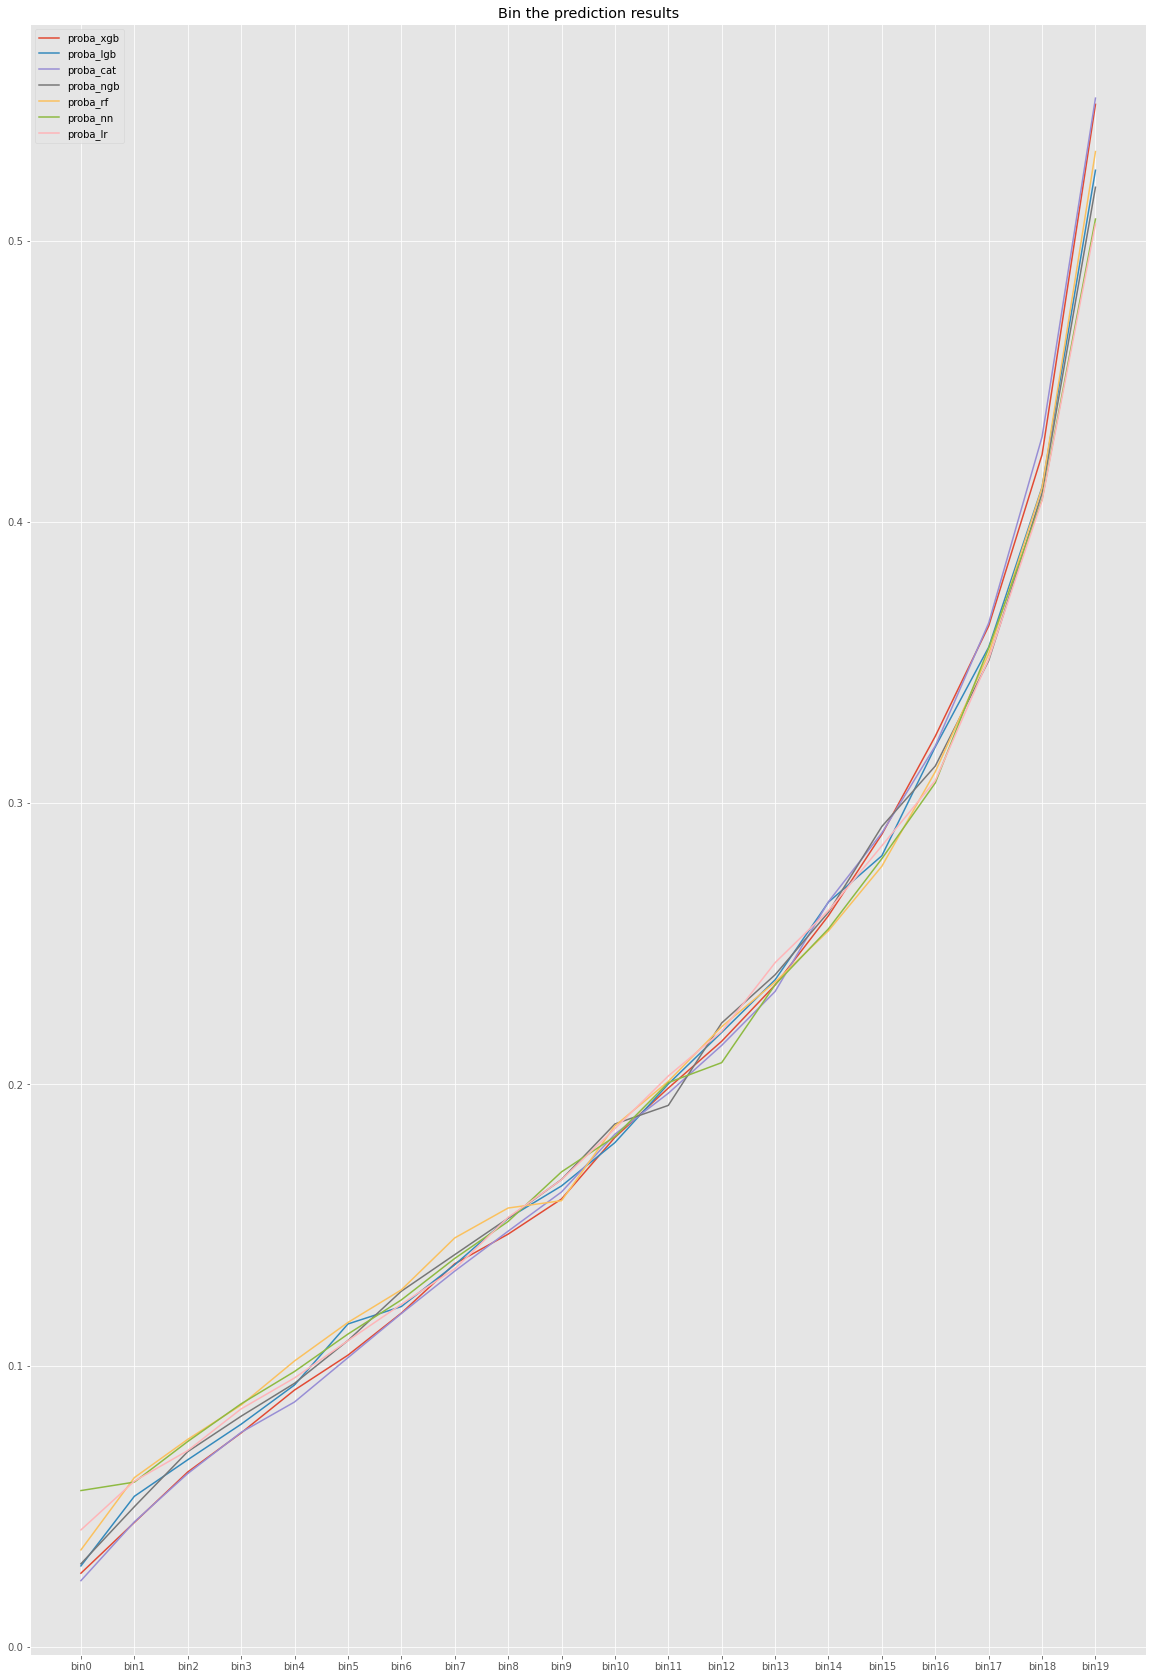

In [74]:
plt.figure(figsize = (20,30))
for colName in ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]:
    bin_col_name = f"{colName}-bin"
    cross.loc[:, bin_col_name], short_score_bin = pd.qcut(
        cross[colName], q=20, retbins=True, labels=False
    )
    group_new = cross.groupby(bin_col_name)
    v1_bin = group_new["label"].sum()/group_new['label'].count()
    plt.plot(x_bins, v1_bin, linewidth=1.5)
    
plt.legend([f'{i}' for i in ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ]])  
plt.title('Bin the prediction results')     
plt.show()

这个图可以看得出来模型对于数据的区分度。

这个图里面，按照预测的评分进行分箱。低分箱的，说明这些样本是坏样本的概率更低，也就是，它们为1的占比也就越小；高分箱反之。

所以，这个图的线应该是单调递增的。

模型越好，这个斜率就越大.并且越高的分箱，比例越大越好；越低的分箱，比例越小越好。

所以，lr的曲线最差；xgb和cat比lgb更好；xgb和cat各有千秋。

------------

上面一席话，是基于lr数据没有标准化的预测结果说的。

数据标准化之后，lr的表现大大接近于三种复杂模型。但是效果上还是差了一点。

# 分箱柱状图以及逐个样本的动支状况

In [60]:
def model_test_nindexs_models(
    df,
    unpaid,
    principal,
    title,
    score_list,
    model_name_list,
    p = 0
):
    '''
    绘制两个图，一个是分箱之后的累积转化率，另一个是按照评分排序之后的逐个样本计算的累积转化率。
    参数解析：
        df: 原来的数据表格。
        unpaid: 说白了就是原始label。
        principal: 说白了就是一列全都是1的列。请在调用这个函数之前，在df里面加入这一列。
        title: 图的title。
        score_list: 说白了就是预测评分的列名。
        model_name_list: 说白了就是图例里面各列的名字。出于简单可以就直接跟列名一样。
        p: 默认是0，说明这个折线从横轴为0的地方开始画；这个值的取值范围是[0,1)，就是从百分之多少开始绘图。有的时候，折线开头会很高，那么
我们就可以用这个参数跳过前面的部分。
    '''
    result = df
    result.reset_index(drop = True, inplace = True)
    
    bin20_result_concat = []
    breaks_list = []
    for i in range(len(score_list)):
        result.sort_values(by = score_list[i], axis = 0, ascending = True, inplace = True)
        result[f'{score_list[i]}_bin20'] = pd.qcut(result[score_list[i]], 20, labels = False) + 1
        
        bins = []
        vintage = []
        for b_i in range(1, 21):
            bins.append(b_i)
            v = result[result[f'{score_list[i]}_bin20'] == b_i][unpaid].sum() / result[result[f'{score_list[i]}_bin20'] == b_i][principal].sum()
            vintage.append(v)

        df_i = pd.DataFrame({'bin': bins, 'vintage' : vintage})
        df_i['model'] = str(i + 1)
        bin20_result_concat.append(df_i)
        breaks_list.append(str(i + 1))
        
    bin20_result_concat = pd.concat(bin20_result_concat)
    
    #plot result
    plotnine.options.figure_size = (16, 8)
    
    ##vintage
    print(ggplot(aes(x = 'bin', y = 'vintage', fill = 'model'), data = bin20_result_concat)
          + geom_bar(stat = 'identity', position = 'dodge', alpha = 0.5) #, alpha = 0.5
          + geom_text(aes(label = round(bin20_result_concat['vintage'], 4)), position = position_dodge(width = 1), size = 8)
          + labs(x = 'bin', y = 'Bin-Wise Cumulative Conversion Rate', title = title)# f'{month}: {title}'
          + scale_fill_hue(name = "Model Type", breaks = breaks_list, 
                           labels = model_name_list)
         )
    
    ##def draw_bad_debt_rate
    def getkey(element):
        return element[0]

    def draw_bad_debt_rate(pred_result):
        pred_result.sort(key = getkey)
        x = []
        y = []
        length = len(pred_result)
        principal_total = 0.
        bad_debt_total = 0.
        for i in range(length):
            x.append((i + 1.0)/length)
            principal_total = principal_total + pred_result[i][1]
            bad_debt_total = bad_debt_total + pred_result[i][2]
            y.append(bad_debt_total / principal_total)
        return x, y
    
    
    ##cumulative
    result_vintage = []
    for i in range(len(score_list)):
        model_x, model_y = draw_bad_debt_rate(
            list(
                zip(
                    result[score_list[i]], ## 把某一评分列拿出来
                    result[principal], ## 全为1的列
                    result[unpaid] ## label
                )
            )
        )
        model_vintage = pd.DataFrame({'pass_rate': model_x, 'cum_vintage': model_y, 'model': str(i + 1)})
        result_vintage.append(model_vintage)
        
    result_vintage = pd.concat(result_vintage)
        
    print(ggplot(aes(x = 'pass_rate', ), data = result_vintage[result_vintage['pass_rate'] >= p]) #[result_vintage['pass_rate'] > ]
          + geom_line(aes(y = 'cum_vintage', color = 'model')) #, alpha = 0.8
          + labs(x = 'DongZhi Rate', y = 'Sample-Wise Cumulative Conversion Rate', title = title) # f'{month} ({result.shape[0]}): {title}'
          + scale_color_hue(name = 'Model Type', breaks = breaks_list, 
                       labels = model_name_list)
        )

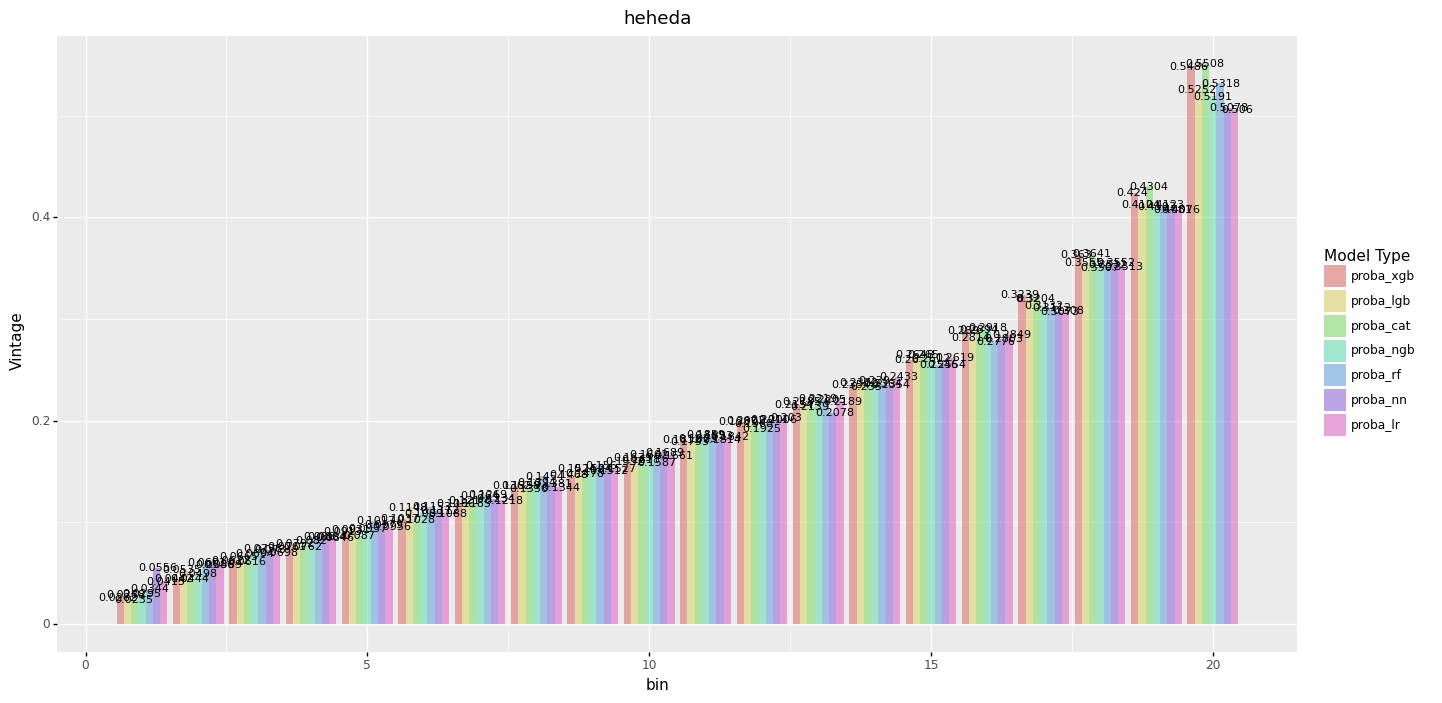

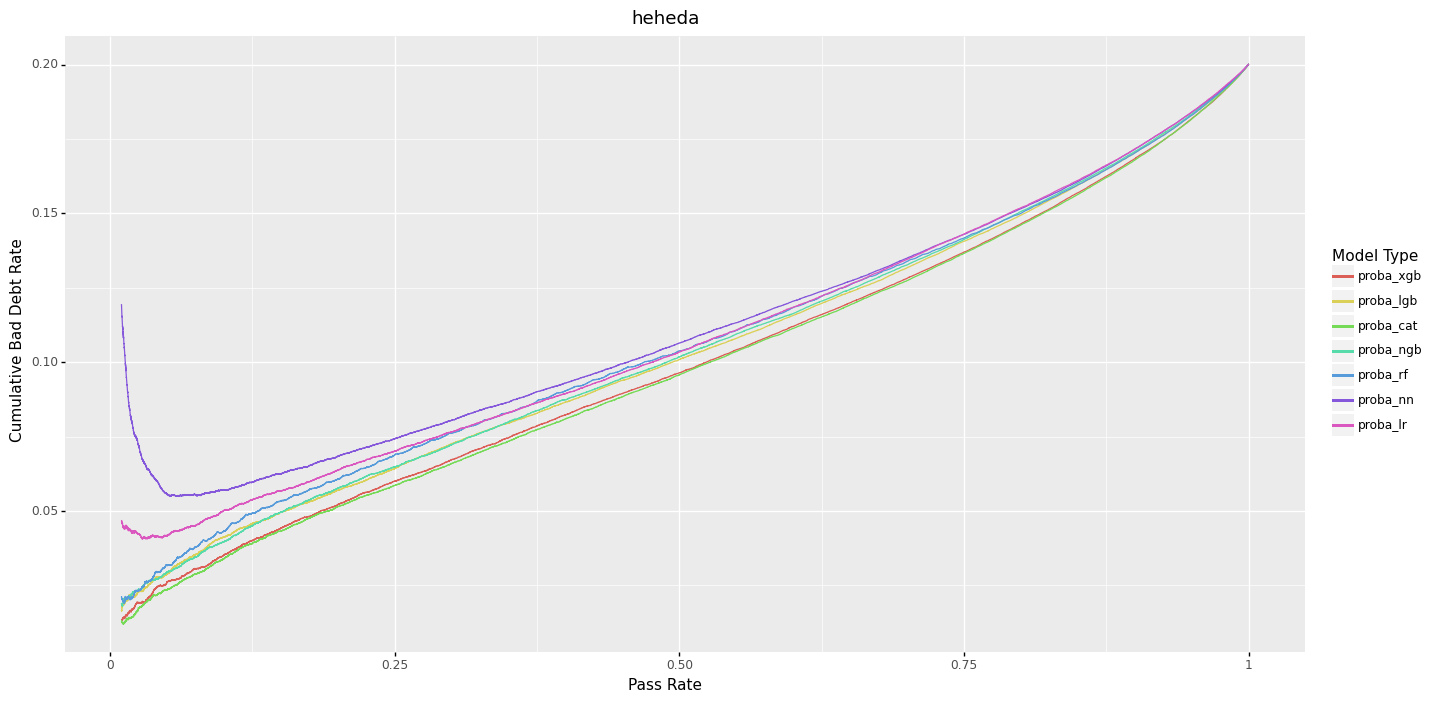

In [95]:
model_test_nindexs_models(
    cross,
    "label", "tag", 
    "heheda", 
    ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ],
    ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", ], 
    0.01
)

/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/rc/5v8dff5j52303vp04pm0xz6c0000gn/T/ipykernel_8519/880441731.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


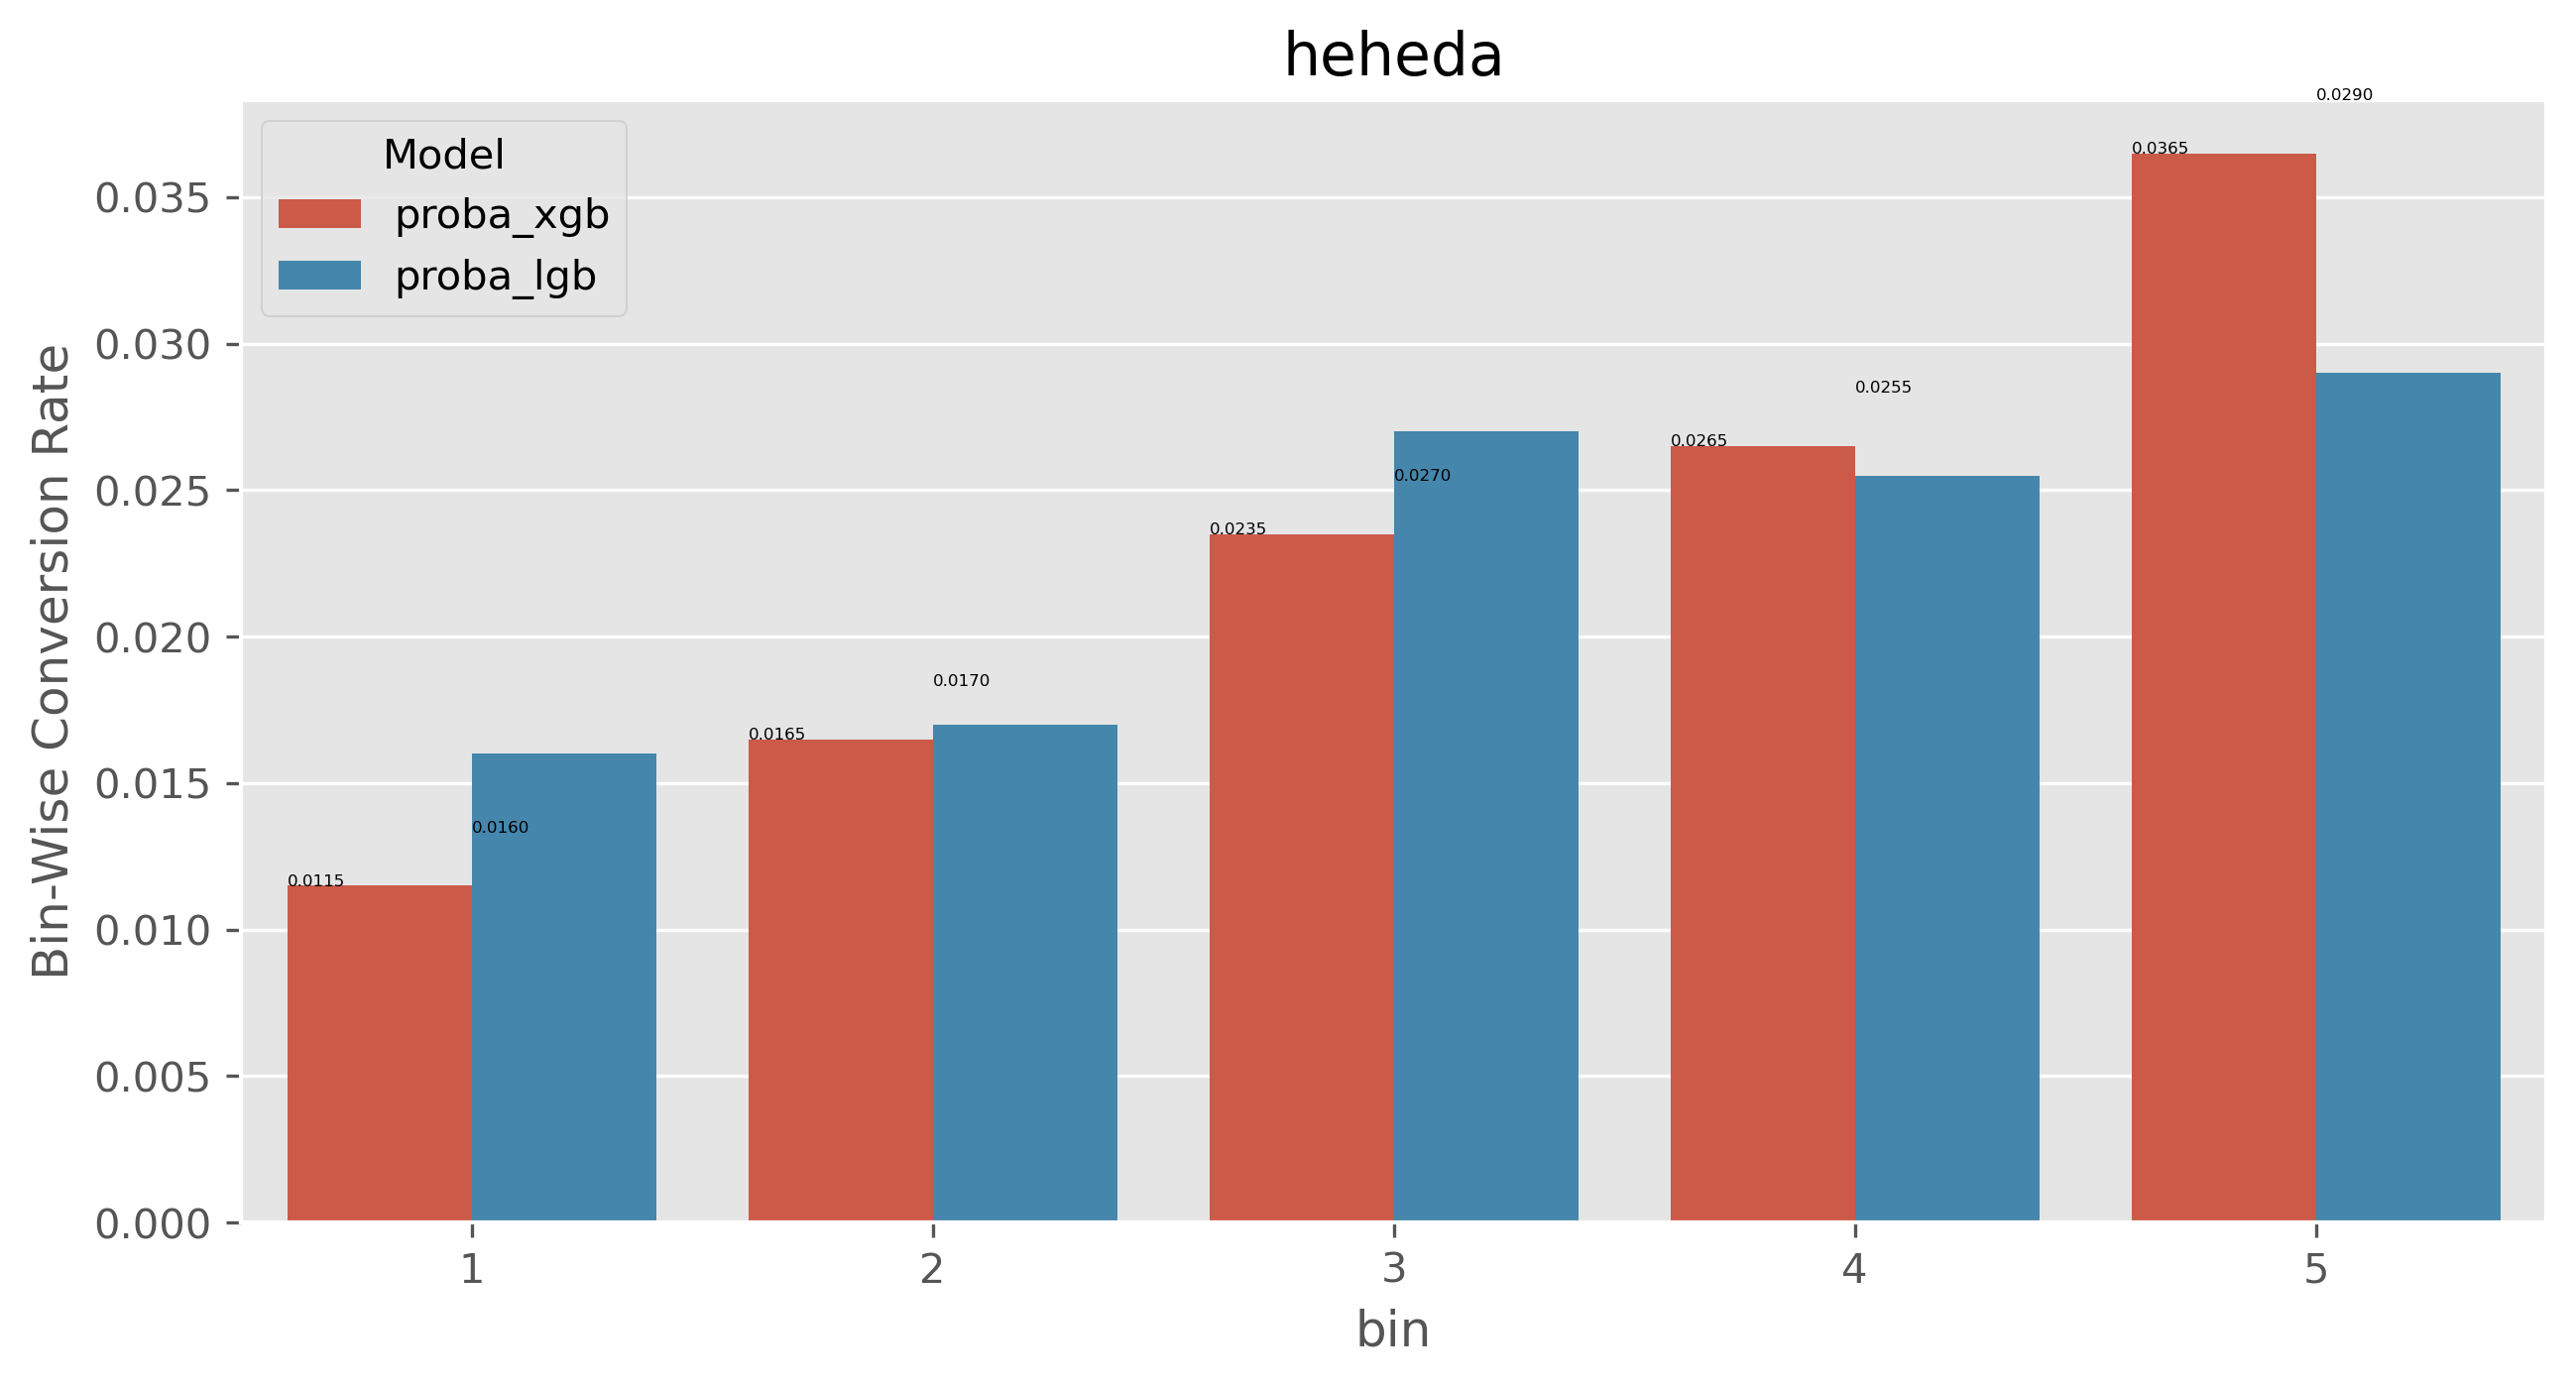

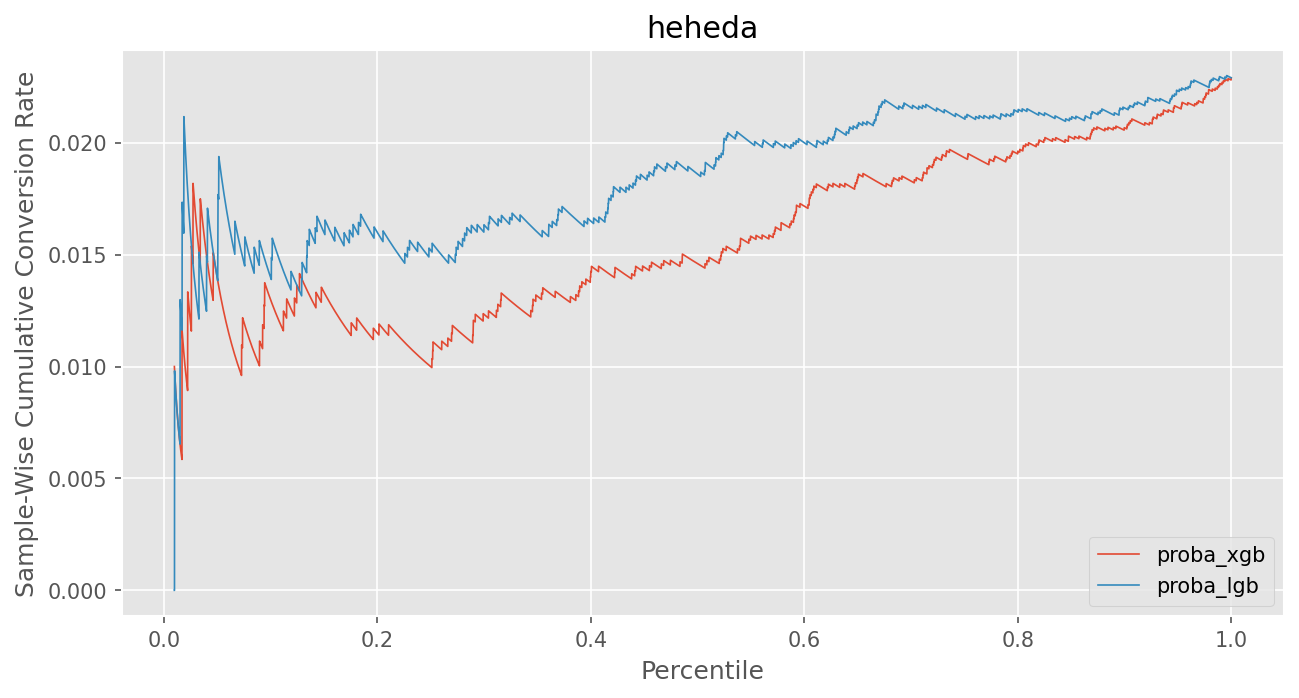

In [205]:
def model_test_nindexs_models_v2(
    df,
    unpaid,
    principal,
    title,
    score_list,
    model_name_list,
    p = 0,
    n_bins = 20
):
    '''
    绘制两个图，一个是分箱之后的累积转化率，另一个是按照评分排序之后的逐个样本计算的累积转化率。
    参数解析：
        df: 原来的数据表格。
        unpaid: 说白了就是原始label。
        principal: 说白了就是一列全都是1的列。请在调用这个函数之前，在df里面加入这一列。
        title: 图的title。
        score_list: 说白了就是预测评分的列名。
        model_name_list: 说白了就是图例里面各列的名字。出于简单可以就直接跟列名一样。
        p: 默认是0，说明这个折线从横轴为0的地方开始画；这个值的取值范围是[0,1)，就是从百分之多少开始绘图。有的时候，折线开头会很高，那么
我们就可以用这个参数跳过前面的部分。
    '''
    result = df
    result.reset_index(drop = True, inplace = True)
    
    bin20_result_concat = []
    breaks_list = []
    for i in range(len(score_list)):
        result.sort_values(by = score_list[i], axis = 0, ascending = True, inplace = True)
        result[f'{score_list[i]}_bin20'] = pd.qcut(result[score_list[i]], n_bins, labels = False) + 1
        
        bins = []
        vintage = []
        for b_i in range(1, n_bins + 1):
            bins.append(b_i)
            v = result[result[f'{score_list[i]}_bin20'] == b_i][unpaid].sum() / result[result[f'{score_list[i]}_bin20'] == b_i][principal].sum()
            vintage.append(v)

        df_i = pd.DataFrame({'bin': bins, 'vintage' : vintage})
        df_i['model'] = str(i + 1)
        bin20_result_concat.append(df_i)
        breaks_list.append(str(i + 1))
        
    bin20_result_concat = pd.concat(bin20_result_concat)
    ##################
    plt.figure(figsize=(10, 5), dpi = 300)
    ax = sns.barplot(
        x="bin", 
        y="vintage", 
        hue="model", 
        data=bin20_result_concat,
        # dodge=False
    )
            
    ax.set_title(title)
    h, l = ax.get_legend_handles_labels() ## https://stackoverflow.com/questions/53734332/seaborn-barplot-legend-labels-lose-color
    ax.legend(h, model_name_list, title = "Model")
    
    first_height_of_patches = [ptc.get_height() for ptc in ax.containers[0]]
    itv = max(first_height_of_patches) / 20
    for i, container in enumerate(ax.containers): 
        ## 某种颜色的所有柱子组成了一个container。
        ## container包含了一系列的patch，每一个patch给我的感觉就是柱状图里的柱那些个矩形。
        xs = [ptc.get_xy()[0] for ptc in container]## get_xy获得每一个柱子的左下角坐标。
        ys = [h + i * itv for h in first_height_of_patches] ## 位置错开一点
        vals = [ptc.get_height() for ptc in container] ## get_height是每一个柱子的高度。
        for x, y, val in zip(xs, ys, vals):
            ax.text(x, y, "%.4f"%val, fontsize = 4) ## 这种方法就是手动在图上标出某个字符串。
        ## ax.bar_label(container, fontsize=3) ## 这种方法也能标注数字，但是标注的位置是定死的，导致标注字符容易重叠。
    
    plt.xlabel("bin")
    plt.ylabel("Bin-Wise Conversion Rate")
    plt.show()    
    
    ################
    def getkey(element):
        return element[0]

    def draw_bad_debt_rate(pred_result):
        pred_result.sort(key = getkey)
        x = []
        y = []
        length = len(pred_result)
        principal_total = 0.
        bad_debt_total = 0.
        for i in range(length):
            x.append((i + 1.0)/length)
            principal_total = principal_total + pred_result[i][1]
            bad_debt_total = bad_debt_total + pred_result[i][2]
            y.append(bad_debt_total / principal_total)
        return x, y
    
    
    ##cumulative
    result_vintage = []
    for i in range(len(score_list)):
        model_x, model_y = draw_bad_debt_rate(
            list(
                zip(
                    result[score_list[i]], ## 把某一评分列拿出来
                    result[principal], ## 全为1的列
                    result[unpaid] ## label
                )
            )
        )
        model_vintage = pd.DataFrame({'pass_rate': model_x, 'cum_vintage': model_y, 'model': str(i + 1)})
        result_vintage.append(model_vintage)
        
    result_vintage = pd.concat(result_vintage)
    ################
    plt.figure(figsize=(10, 5), dpi = 150)
    ax = sns.lineplot(
        x="pass_rate", 
        y="cum_vintage", 
        hue="model", 
        data=result_vintage[result_vintage['pass_rate'] >= p].reset_index(drop = True),
        linewidth = 0.8
    )
    ax.set_title(title)
    h, l = ax.get_legend_handles_labels() ## https://stackoverflow.com/questions/53734332/seaborn-barplot-legend-labels-lose-color
    ax.legend(h, model_name_list, title = "Model")
    plt.xlabel('Percentile')
    plt.ylabel('Sample-Wise Cumulative Conversion Rate')
    plt.legend(model_name_list)
    plt.show()
    
model_test_nindexs_models_v2(
    cross.head(10000),
    "label", "tag", 
    "heheda", 
    ["proba_xgb", "proba_lgb"], # , "proba_ngb", "proba_rf", "proba_nn", "proba_lr", 
    ["proba_xgb", "proba_lgb"], #  , "proba_ngb", "proba_rf", "proba_nn", "proba_lr", 
    0.01,
    5
)

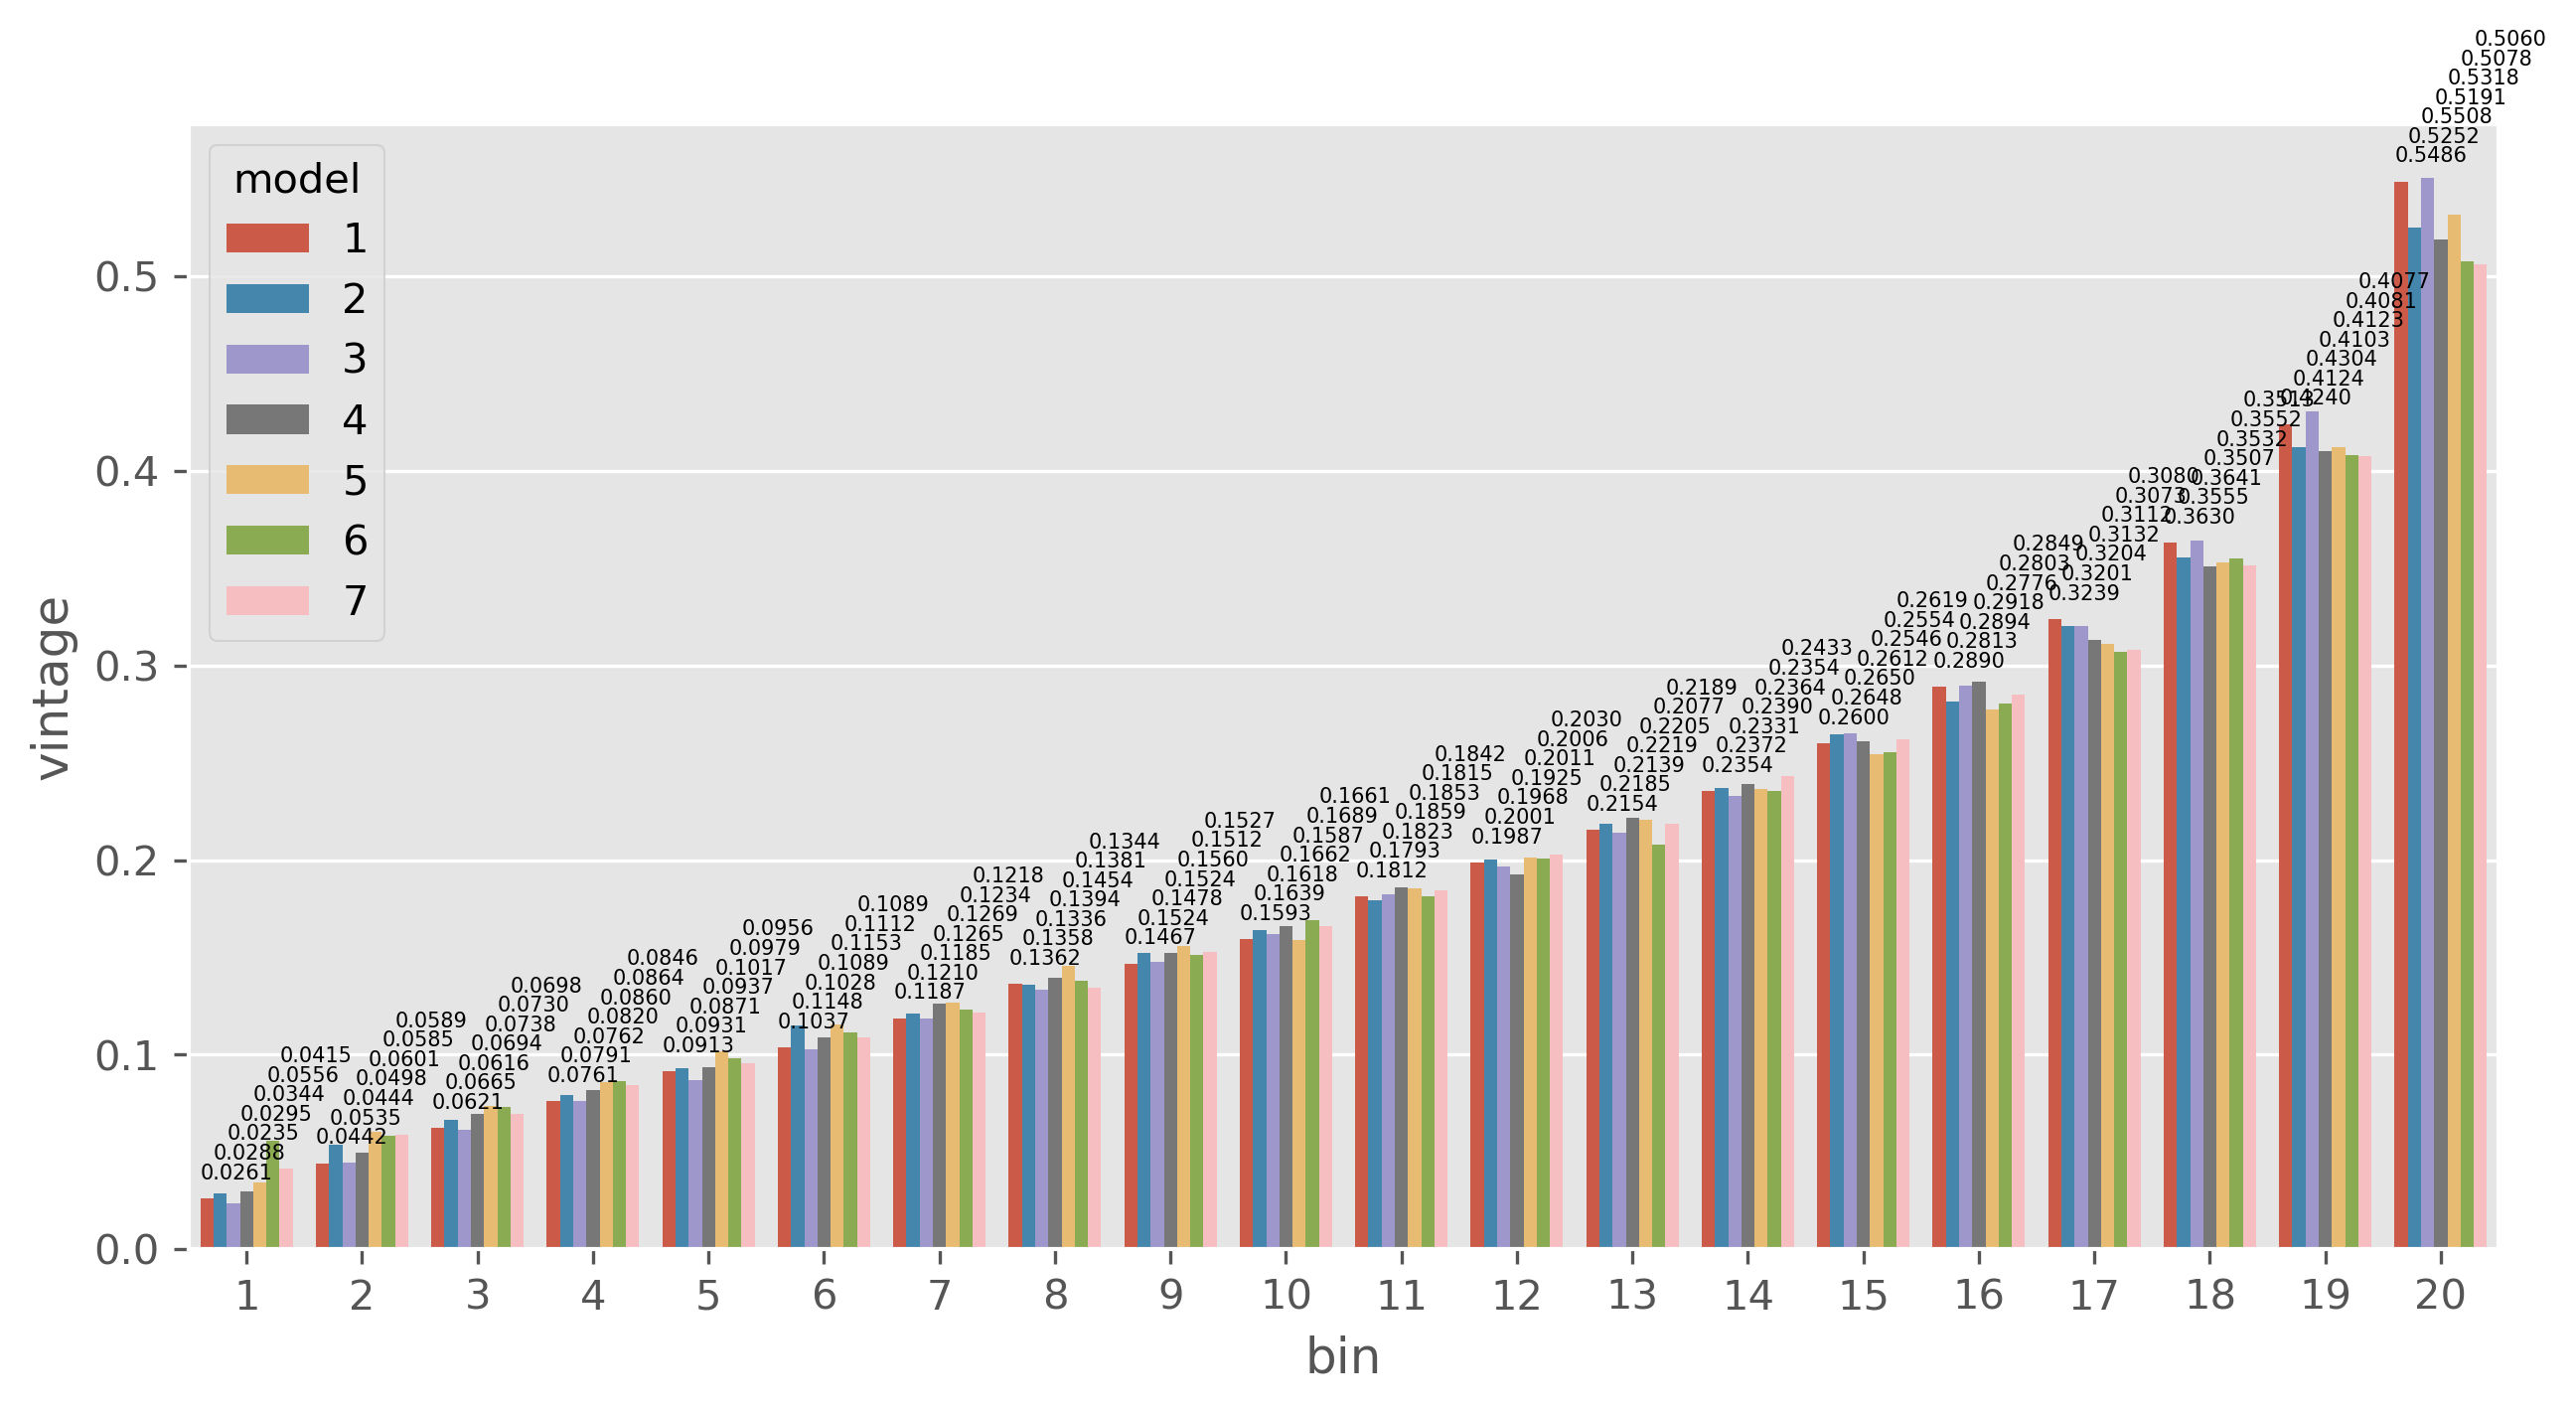

In [190]:
import copy
plt.figure(figsize=(10, 5), dpi = 300)
ax = sns.barplot(
    x="bin", 
    y="vintage", 
    hue="model", 
    data=bin20_result_concat,
)

first_height_of_patches = [ptc.get_height() + 0.01 for ptc in ax.containers[0]]
for i, container in enumerate(ax.containers): 
    xs = [ptc.get_xy()[0] for ptc in container]
    ys = [h + i * 0.01 for h in first_height_of_patches]
    vals = [ptc.get_height() for ptc in container]
    for x, y, val in zip(xs, ys, vals):
        ax.text(x, y, "%.4f"%val, fontsize = 5)
        
plt.show()

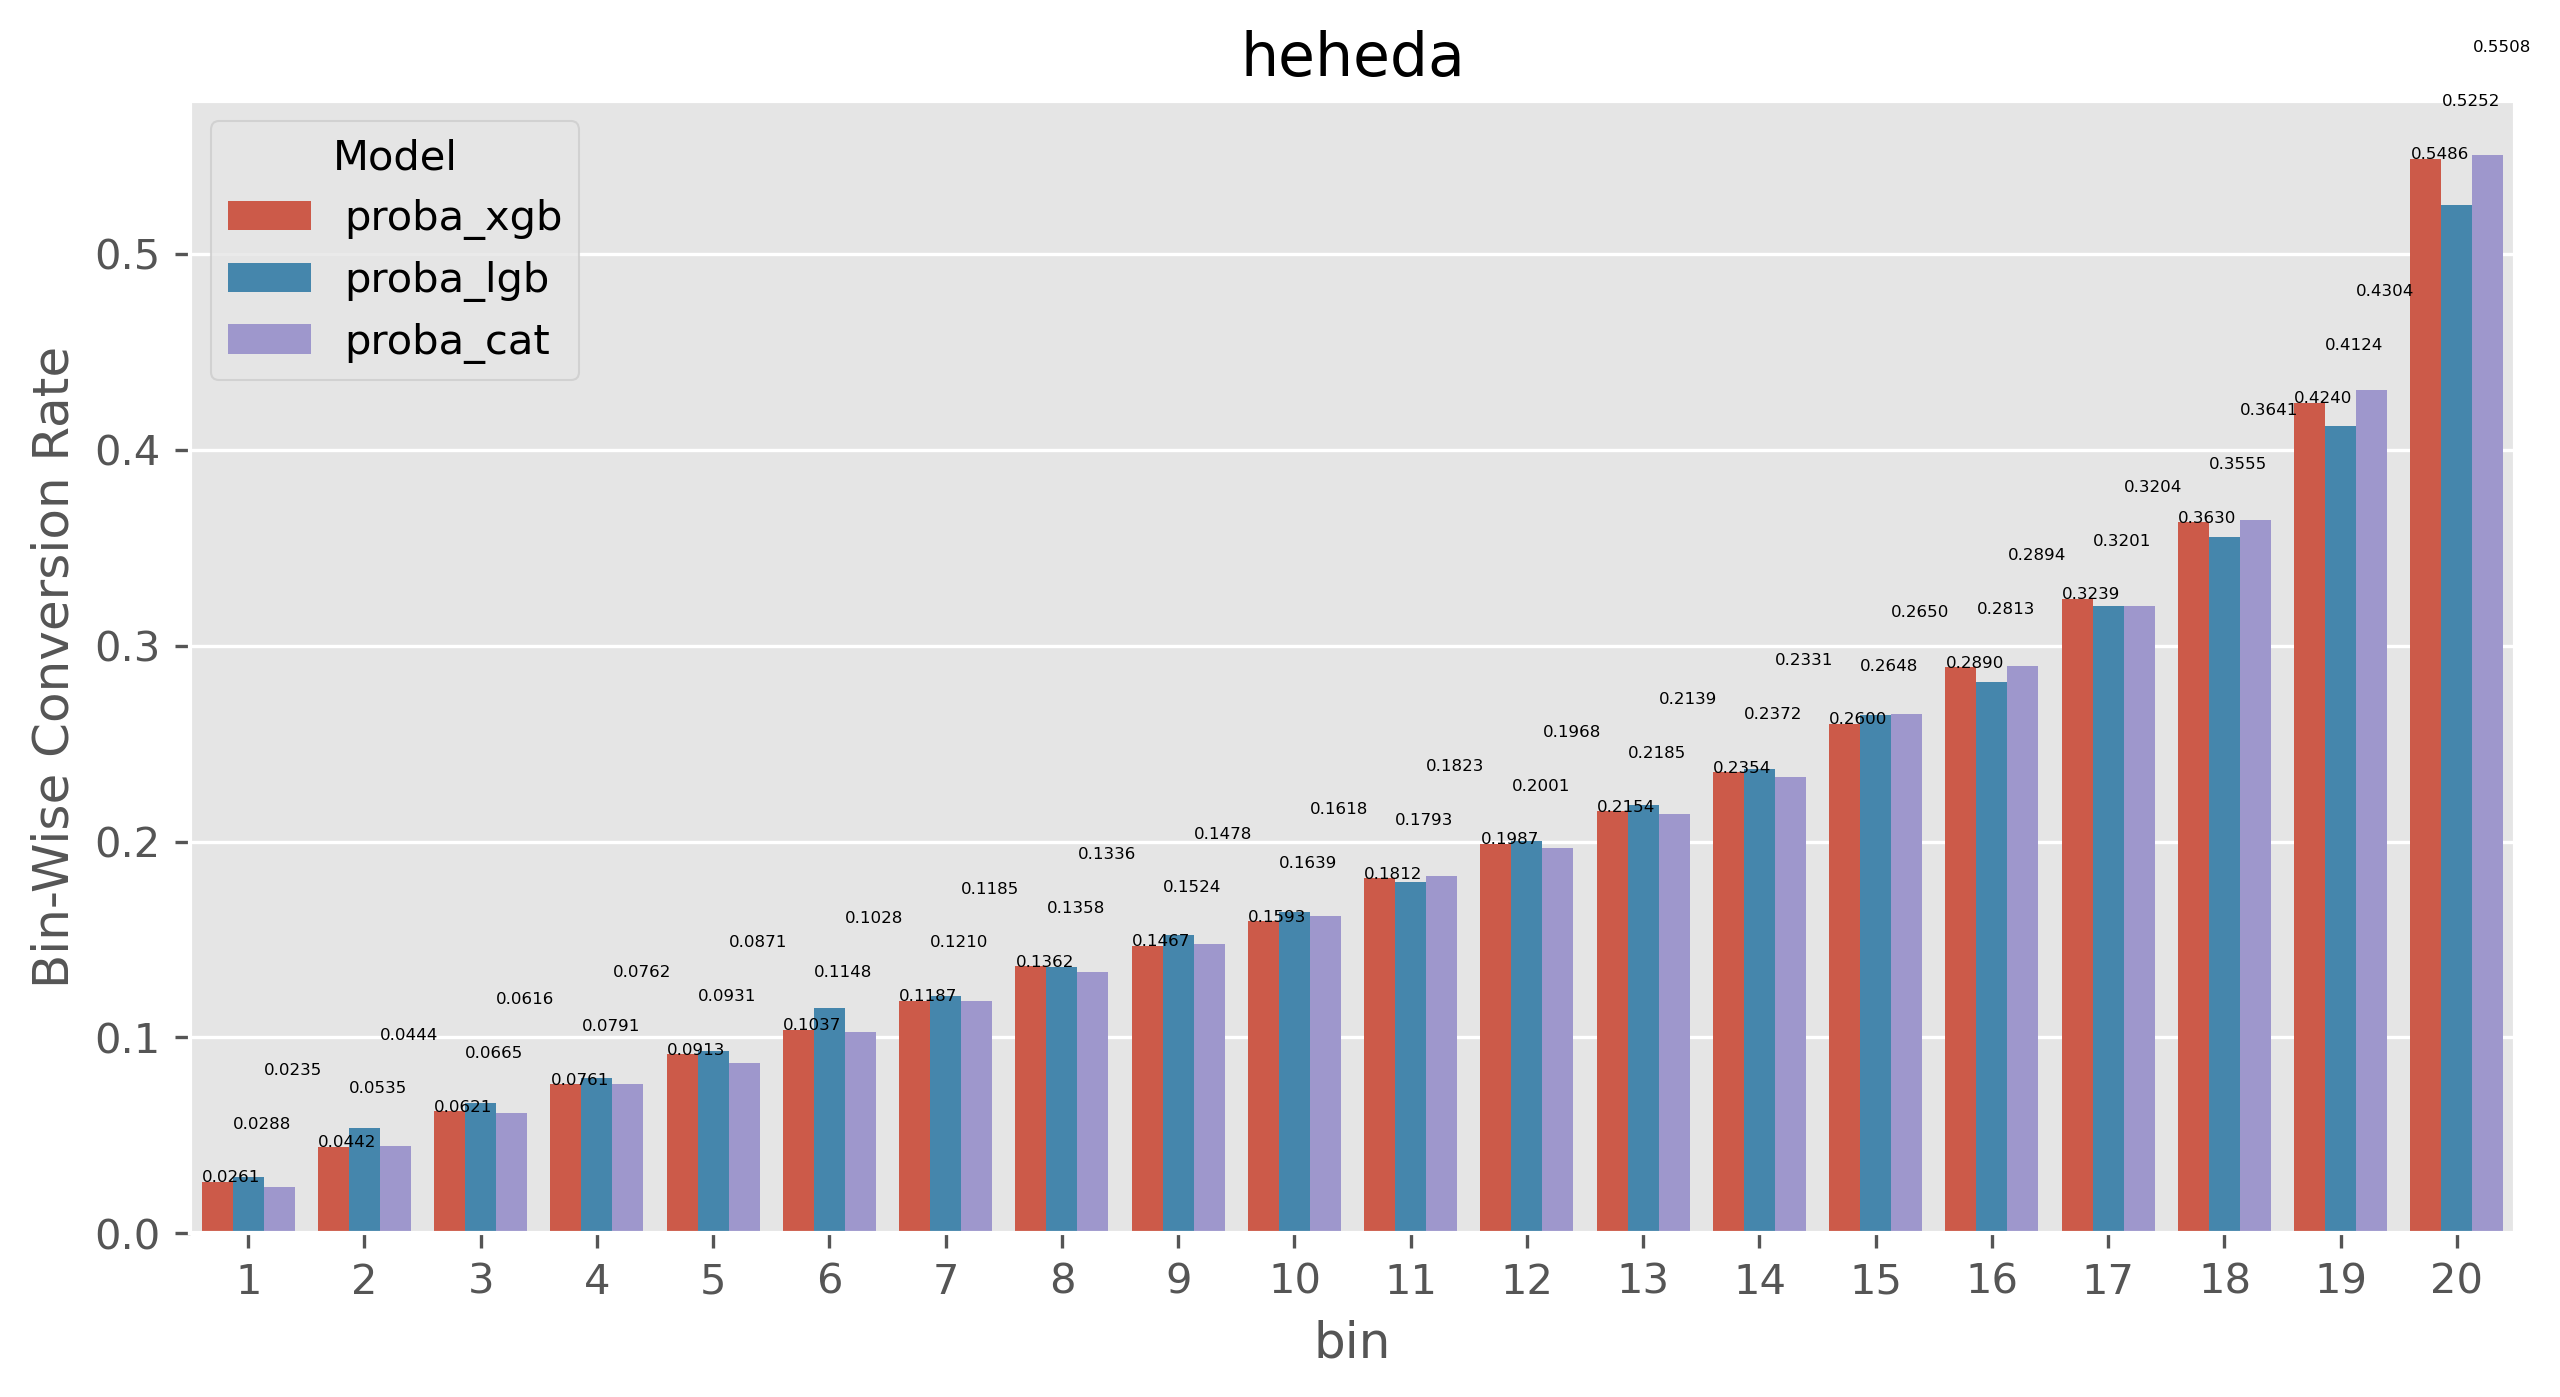

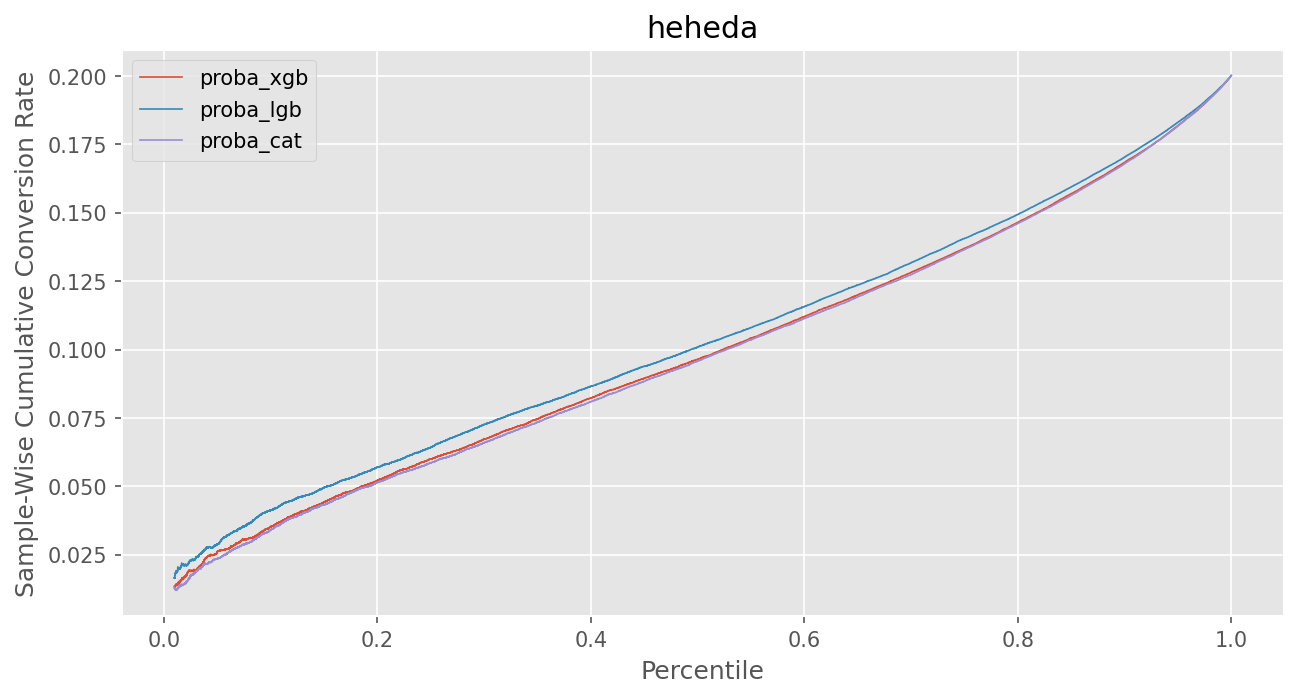

In [200]:
model_test_nindexs_models_v2(
    cross,
    "label", "tag", 
    "heheda", 
    ["proba_xgb", "proba_lgb", "proba_cat"], # , "proba_ngb", "proba_rf", "proba_nn", "proba_lr", 
    ["proba_xgb", "proba_lgb", "proba_cat"], #  , "proba_ngb", "proba_rf", "proba_nn", "proba_lr", 
    0.01,
    
)

# 动支模型分箱x各种label

效果如下：

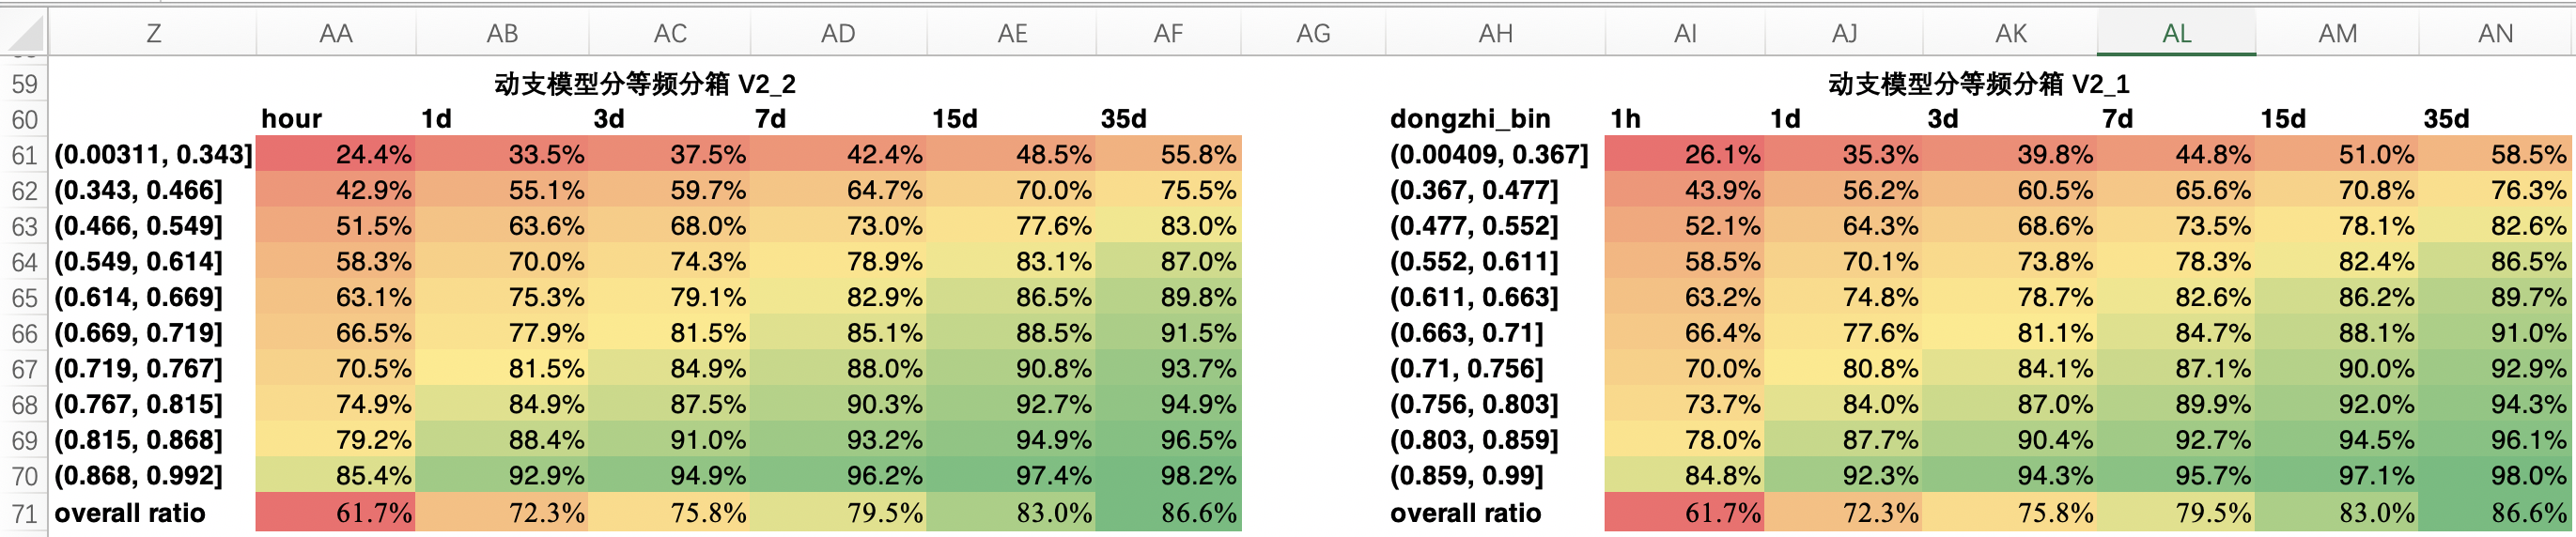

In [22]:
cross.head()

,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label,lr_bin,xgb_bin,...,proba_rf-pred,proba_nn-pred,proba_lr-pred,proba_xgb-bin,proba_lgb-bin,proba_cat-bin,proba_ngb-bin,proba_rf-bin,proba_nn-bin,proba_lr-bin
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.137315,0.074103,0,"(-0.0009999791, 0.0959]","(0.199, 0.311]",...,0,0,0,5,2,6,3,5,8,2
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.338541,0.246083,0,"(0.198, 0.287]","(0.424, 0.561]",...,1,1,1,15,11,15,14,17,16,14
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.100600,0.138985,1,"(0.0959, 0.143]","(0.311, 0.424]",...,0,0,0,8,13,9,10,8,5,7
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.056128,0.085660,0,"(-0.0009999791, 0.0959]","(0.0006999999999999999, 0.199]",...,0,0,0,3,4,2,1,1,2,3
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.139695,0.296222,0,"(0.287, 1.0]","(0.199, 0.311]",...,1,0,1,6,1,6,8,14,8,16


In [23]:
cur_matrix = pd.DataFrame(
    {
        k:v for v, k in zip(
            [proba_xgb, proba_lgb, proba_cat, proba_ngb, proba_rf, proba_nn, proba_lr, y_test], 
            ["proba_xgb", "proba_lgb", "proba_cat", "proba_ngb", "proba_rf", "proba_nn", "proba_lr", "label"]
        )
    }
)
cur_matrix.head()

,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.137315,0.074103,0
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.338541,0.246083,0
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.100600,0.138985,1
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.056128,0.085660,0
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.139695,0.296222,0


In [24]:
for i in range(5): ## 我们生成5个不同的label组合吧
    _, y_ = make_classification(
        n_samples=y_test.shape[0], 
        n_features=10, 
        random_state=i
    )
    cur_matrix[f"label_{i}"] = y_
cur_matrix.head()

,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label,label_0,label_1,label_2,label_3,label_4
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.137315,0.074103,0,1,0,0,0,0
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.338541,0.246083,0,1,1,0,0,0
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.100600,0.138985,1,1,1,1,1,1
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.056128,0.085660,0,1,1,0,1,0
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.139695,0.296222,0,0,0,0,0,1


In [25]:
colName = "proba_cat"
cur_matrix[colName + "-bin"] = pd.qcut(
    cur_matrix[colName], q = 20
)
cur_matrix.head()

,proba_xgb,proba_lgb,proba_cat,proba_ngb,proba_rf,proba_nn,proba_lr,label,label_0,label_1,label_2,label_3,label_4,proba_cat-bin
158171,0.249611,0.068723,0.115439,0.089050,0.125,0.137315,0.074103,0,1,0,0,0,0,"(0.108, 0.122]"
480078,0.541855,0.203873,0.280947,0.244323,0.360,0.338541,0.246083,0,1,1,0,0,0,"(0.272, 0.303]"
258275,0.338621,0.236138,0.158161,0.185616,0.165,0.100600,0.138985,1,1,1,1,1,1,"(0.152, 0.168]"
20237,0.178800,0.092924,0.063976,0.068934,0.055,0.056128,0.085660,0,1,1,0,1,0,"(0.0536, 0.0673]"
354111,0.281470,0.063590,0.120332,0.163832,0.280,0.139695,0.296222,0,0,0,0,0,1,"(0.108, 0.122]"


In [26]:
rsts = {}
for i in range(5):
    rsts[f"label_{i}_prop"] = cur_matrix.groupby(colName + "-bin")[f"label_{i}"].mean()

In [27]:
rsts_df = pd.DataFrame(rsts)
rsts_df

,label_0_prop,label_1_prop,label_2_prop,label_3_prop,label_4_prop
proba_cat-bin,,,,,
"(0.00587, 0.0393]",0.49820,0.50415,0.50025,0.50320,0.50140
"(0.0393, 0.0536]",0.49865,0.49585,0.49755,0.50395,0.49815
"(0.0536, 0.0673]",0.50020,0.49715,0.49615,0.49990,0.50150
"(0.0673, 0.0807]",0.49890,0.49860,0.50390,0.50205,0.49870
"(0.0807, 0.0945]",0.50485,0.50470,0.50465,0.50095,0.49945
"(0.0945, 0.108]",0.50175,0.50155,0.50510,0.50265,0.49935
"(0.108, 0.122]",0.49280,0.50135,0.49700,0.49720,0.49945
"(0.122, 0.137]",0.50140,0.49380,0.50040,0.50050,0.49510
"(0.137, 0.152]",0.49710,0.49980,0.49490,0.49270,0.50135


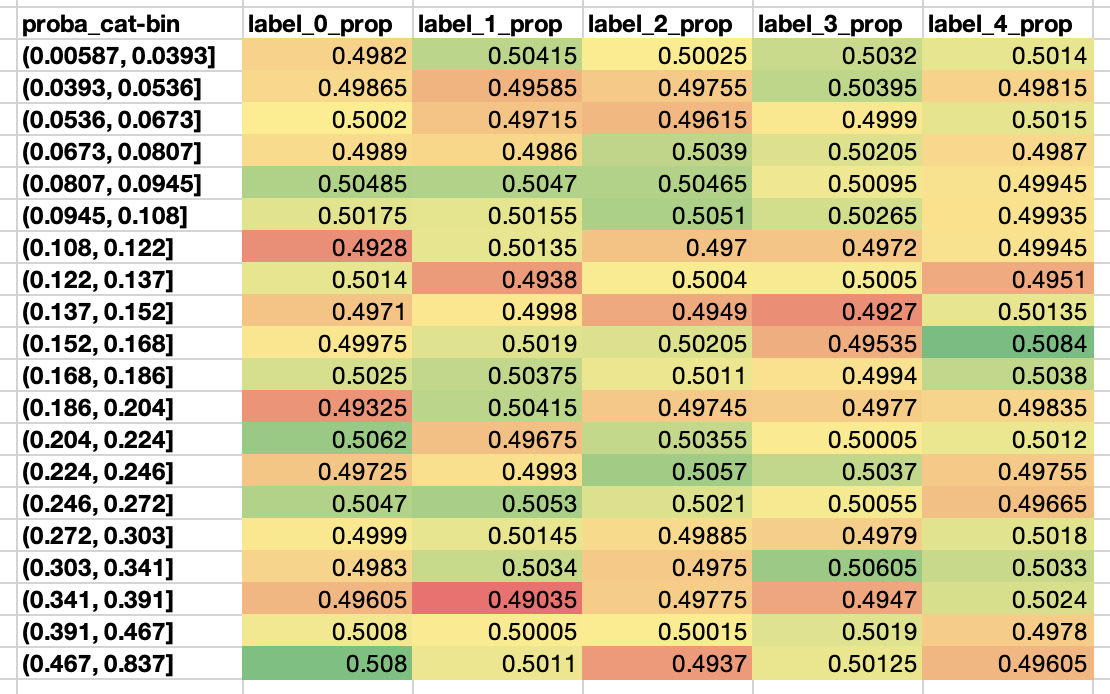

基本复刻了。

# 作热力图

In [28]:
def reshape_unstacked_table(ct):
    '''
    这个可以把unstack的表格给它的列名重新排一下。
    ct: unstacked table that is to be reshaped.
    '''
    new_columns = []
    for i in ct.columns.to_frame().index:
        new_columns.append(str(i))

    new_indices = []
    for i in ct.index.to_frame().index:
        new_indices.append(str(i))

    tmp_table = pd.DataFrame(
        ct.to_numpy(), 
        columns=new_columns,
    )
    tmp_table["tmp_idx"] = new_indices
    tmp_table.set_index(["tmp_idx"], inplace=True)
    
    return tmp_table

tmp = reshape_unstacked_table(cross_)

真·画图的模版

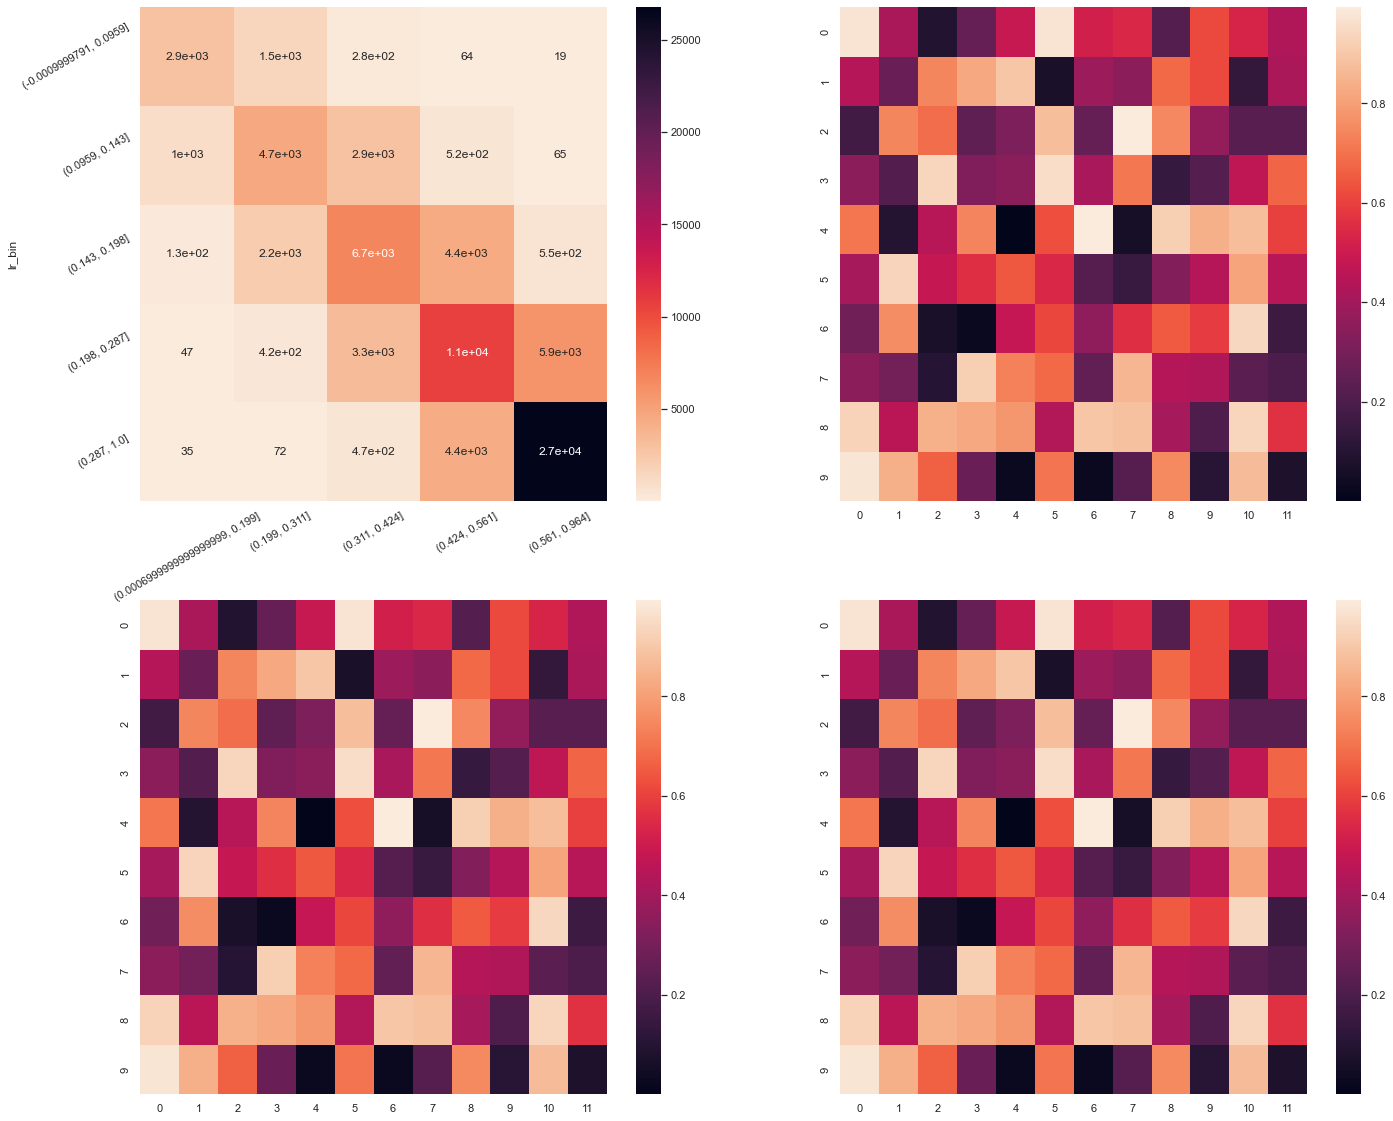

In [29]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
uniform_data = np.random.rand(10, 12)
## 定义一下多图并列：
f, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2, 2, figsize=(23, 20))
sns.heatmap(cross_, ax = ax0, cmap = sns.cm.rocket_r, annot=True) 
## `cmap = sns.cm.rocket_r`表示，值越大则颜色越深；默认是反过来的。
## annot=True就可以把数字填进去。
sns.heatmap(uniform_data, ax = ax1)
sns.heatmap(uniform_data, ax = ax2)
sns.heatmap(uniform_data, ax = ax3)

## x, y轴的反转：
# ax0.invert_xaxis()
# ax1.invert_yaxis()
# ax2.invert_yaxis()
# ax3.invert_yaxis()

## 旋转轴的标签：
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=30)
ax0.set_yticklabels(ax0.get_yticklabels(),rotation=30)

plt.show()

一般要注意作三个图：
* 每一个格子里面的样本数。
* 格子里面的样本量/总样本量。或者说，所有格子里面的值加起来得是1。
* 格子里面label的mean；或者说格子里面label为1的比例。

实际演示一下吧：

In [21]:
count_rst = cross.groupby(['lr_bin', 'xgb_bin'])["label"].count().unstack()
count_rst

xgb_bin,"(0.0006999999999999999, 0.196]","(0.196, 0.305]","(0.305, 0.417]","(0.417, 0.553]","(0.553, 0.964]"
lr_bin,,,,,
"(-0.0009999802, 0.0962]",60068,16795,2571,446,120
"(0.0962, 0.144]",16184,41532,19220,2843,221
"(0.144, 0.2]",2314,18227,38169,19491,1799
"(0.2, 0.287]",803,2972,17993,41769,16463
"(0.287, 1.0]",631,474,2047,15451,61397


In [22]:
prop_rst = count_rst / X_test.shape[0]
prop_rst

xgb_bin,"(0.0006999999999999999, 0.196]","(0.196, 0.305]","(0.305, 0.417]","(0.417, 0.553]","(0.553, 0.964]"
lr_bin,,,,,
"(-0.0009999802, 0.0962]",0.150170,0.041987,0.006428,0.001115,0.000300
"(0.0962, 0.144]",0.040460,0.103830,0.048050,0.007108,0.000553
"(0.144, 0.2]",0.005785,0.045567,0.095422,0.048727,0.004497
"(0.2, 0.287]",0.002008,0.007430,0.044983,0.104423,0.041157
"(0.287, 1.0]",0.001577,0.001185,0.005117,0.038628,0.153493


In [23]:
labelMean_rst = cross.groupby(['lr_bin', 'xgb_bin'])["label"].mean().unstack()
labelMean_rst

xgb_bin,"(0.0006999999999999999, 0.196]","(0.196, 0.305]","(0.305, 0.417]","(0.417, 0.553]","(0.553, 0.964]"
lr_bin,,,,,
"(-0.0009999802, 0.0962]",0.047513,0.100268,0.159860,0.233184,0.358333
"(0.0962, 0.144]",0.066609,0.107700,0.155983,0.209989,0.303167
"(0.144, 0.2]",0.067848,0.128107,0.170976,0.231440,0.329072
"(0.2, 0.287]",0.058531,0.146703,0.187684,0.252891,0.349633
"(0.287, 1.0]",0.055468,0.145570,0.197851,0.273057,0.435396


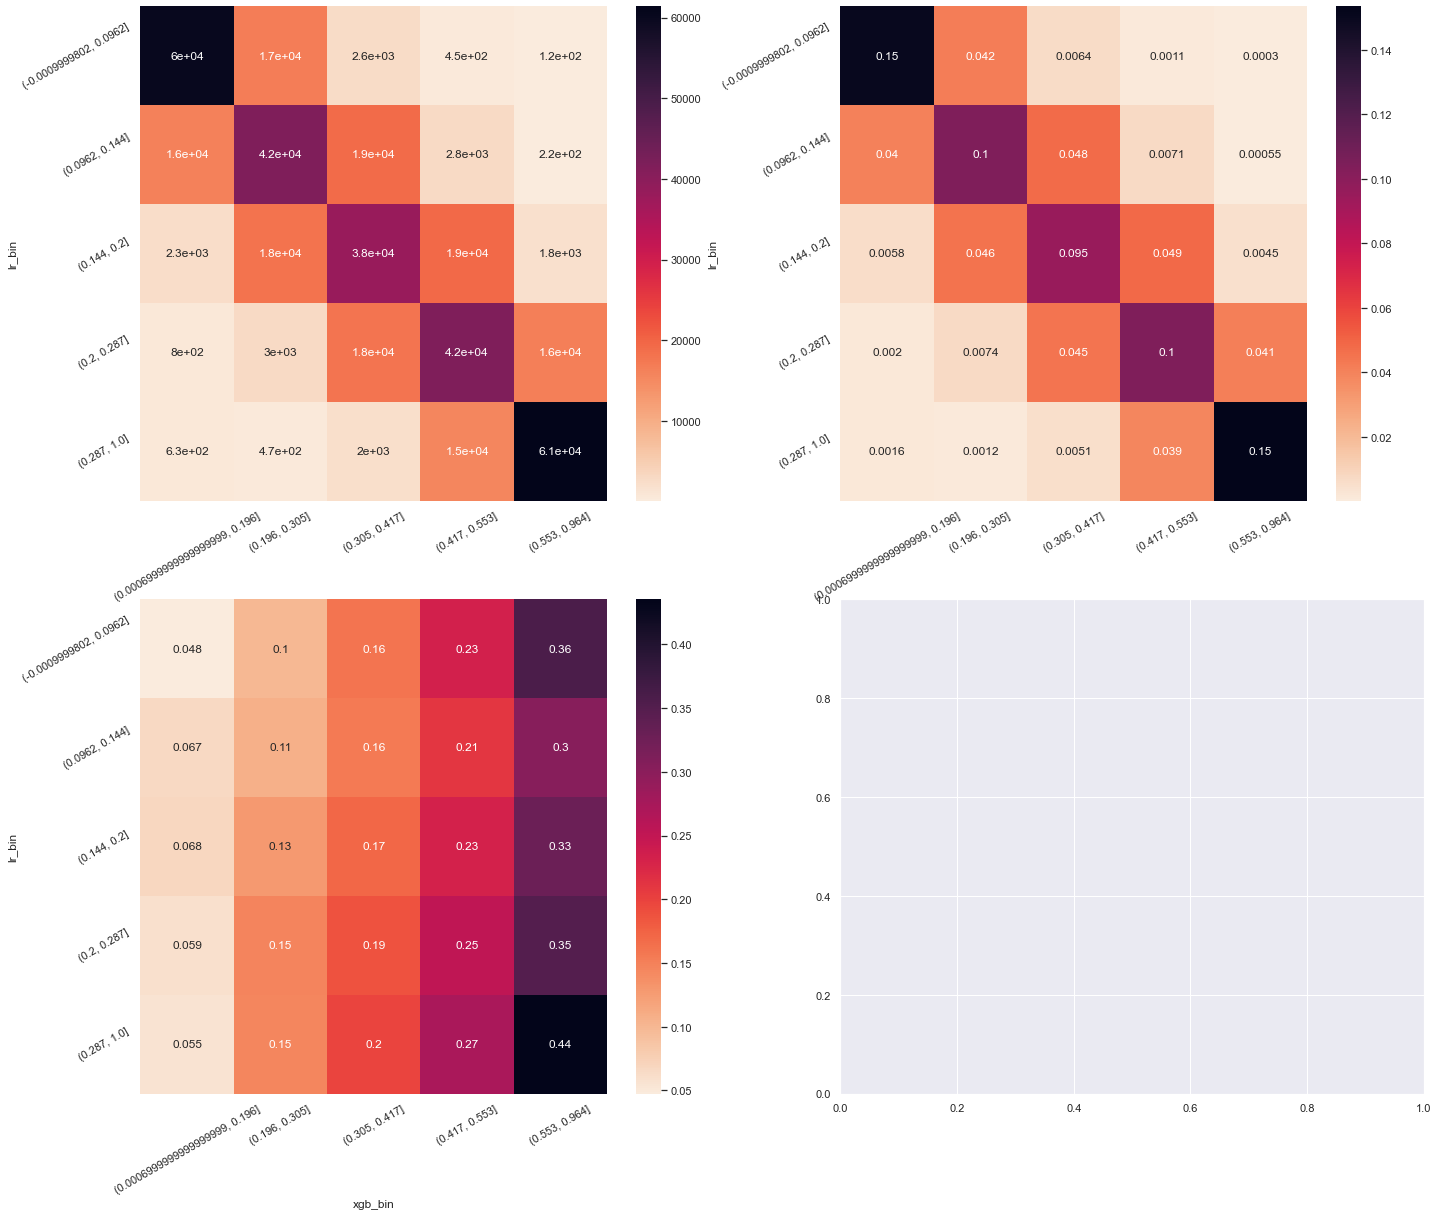

In [24]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

## 定义一下多图并列：
f, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2, 2, figsize=(23, 20))
sns.heatmap(count_rst, ax = ax0, cmap = sns.cm.rocket_r, annot=True) 
sns.heatmap(prop_rst, ax = ax1, cmap = sns.cm.rocket_r, annot=True)
sns.heatmap(labelMean_rst, ax = ax2, cmap = sns.cm.rocket_r, annot=True)

## 旋转轴的标签：
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=30)
ax0.set_yticklabels(ax0.get_yticklabels(),rotation=30)

ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_yticklabels(ax1.get_yticklabels(),rotation=30)

ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30)
ax2.set_yticklabels(ax2.get_yticklabels(),rotation=30)

plt.show()

---------

In [175]:
def add_mean_col_and_row(ori_df):
    '''
    这个函数，我们能够给一个按照两列groupby的表格添上横竖的两个平均值overall
    '''
    df1 = pd.concat(
        [ori_df, pd.DataFrame({"overall": ori_df.mean(axis=1)})], axis=1
    )
    df1 = pd.concat(
        [df1, pd.DataFrame({"overall": df1.mean(axis=0)}).T]
    )
    return df1

def add_sum_col_and_row(ori_df):
    '''
    这个函数，我们能够给一个按照两列groupby的表格添上横竖的两个总和overall
    '''
    df1 = pd.concat(
        [ori_df, pd.DataFrame({"overall": ori_df.sum(axis=1)})], axis=1
    )
    df1 = pd.concat(
        [df1, pd.DataFrame({"overall": df1.sum(axis=0)}).T]
    )
    return df1

In [182]:
def create_cross_table_mean(df, colName1, colName2, labelColName, n_bins=5):
    '''
    colName2 will be horizontal axis, colName1 will be vertical axis.
    '''
    df.loc[:,f'{colName1}-bin'] = pd.qcut(df[f'{colName1}'], q=n_bins)
    df.loc[:,f'{colName2}-bin'] = pd.qcut(df[f'{colName2}'], q=n_bins)
    return df.groupby([f'{colName1}-bin', f'{colName2}-bin'])[f"{labelColName}"].mean().unstack()

In [170]:
add_mean_col_and_row(prop_rst)

,"(0.0006999999999999999, 0.196]","(0.196, 0.305]","(0.305, 0.417]","(0.417, 0.553]","(0.553, 0.964]",overall
"(-0.0009999802, 0.0962]",0.150170,0.041987,0.006428,0.001115,0.000300,0.04
"(0.0962, 0.144]",0.040460,0.103830,0.048050,0.007108,0.000553,0.04
"(0.144, 0.2]",0.005785,0.045567,0.095422,0.048727,0.004497,0.04
"(0.2, 0.287]",0.002008,0.007430,0.044983,0.104423,0.041157,0.04
"(0.287, 1.0]",0.001577,0.001185,0.005117,0.038628,0.153493,0.04
overall,0.040000,0.040000,0.040000,0.040000,0.040000,0.04


In [176]:
add_sum_col_and_row(prop_rst)

,"(0.0006999999999999999, 0.196]","(0.196, 0.305]","(0.305, 0.417]","(0.417, 0.553]","(0.553, 0.964]",overall
"(-0.0009999802, 0.0962]",0.150170,0.041987,0.006428,0.001115,0.000300,0.2
"(0.0962, 0.144]",0.040460,0.103830,0.048050,0.007108,0.000553,0.2
"(0.144, 0.2]",0.005785,0.045567,0.095422,0.048727,0.004497,0.2
"(0.2, 0.287]",0.002008,0.007430,0.044983,0.104423,0.041157,0.2
"(0.287, 1.0]",0.001577,0.001185,0.005117,0.038628,0.153493,0.2
overall,0.200000,0.200000,0.200000,0.200000,0.200000,1.0


In [177]:
count_rst_ = add_mean_col_and_row(count_rst)
prop_rst_ = add_mean_col_and_row(prop_rst)

NameError: name 'count_rst_' is not defined

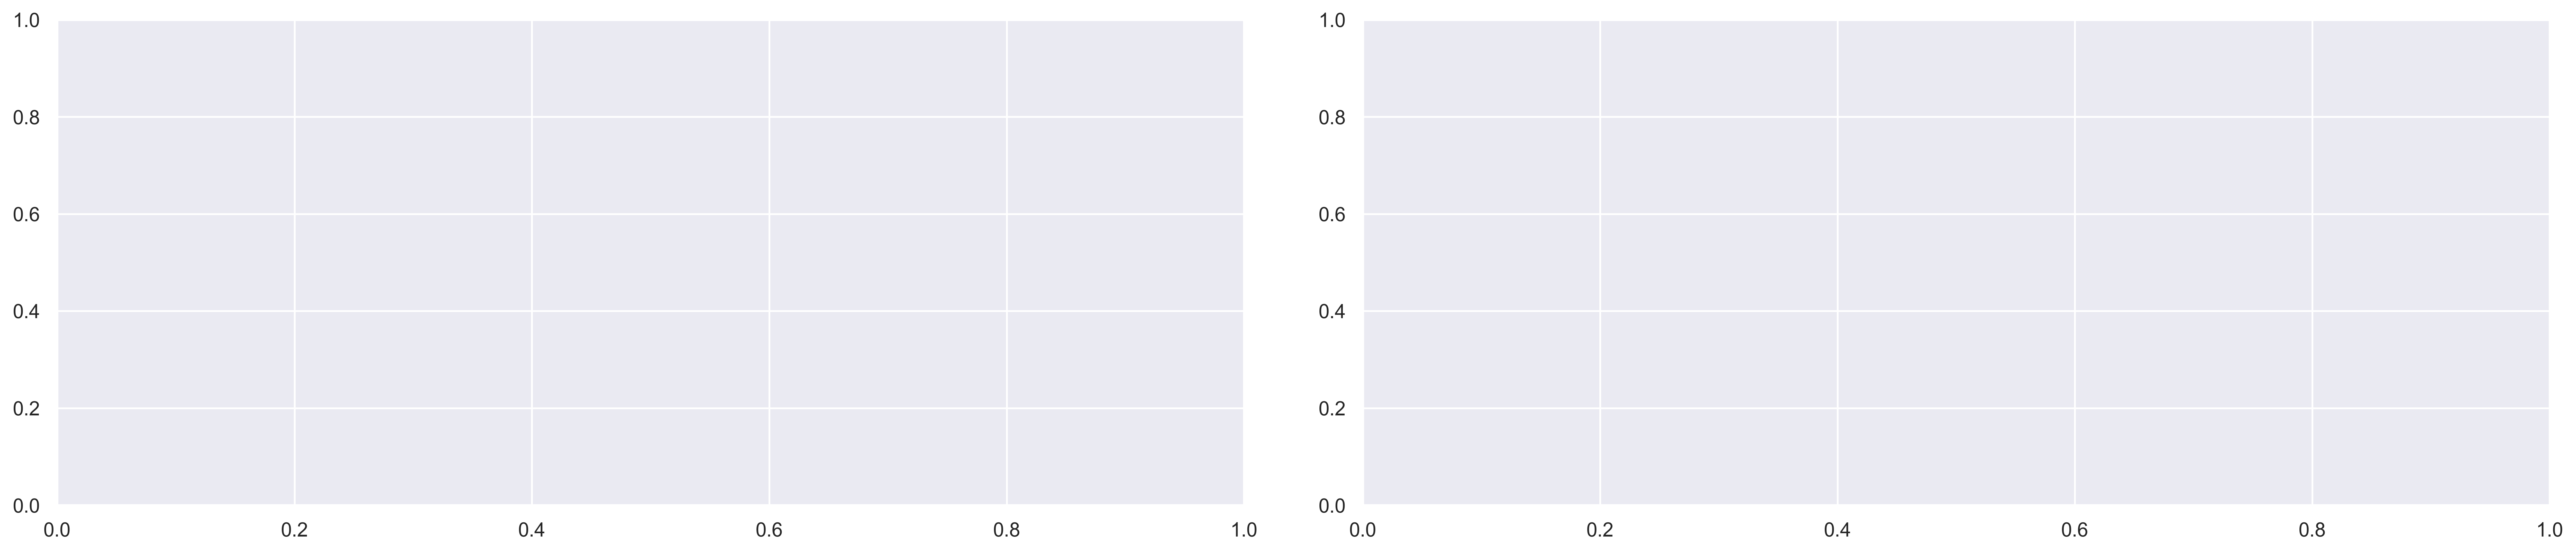

In [1]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

## 定义一下多图并列：
f, [ax0, ax1] = plt.subplots(1, 2, figsize=(25, 5), dpi=500) ## dpi可以调节清晰度
## 调整子图之间的间距（https://blog.csdn.net/Hodors/article/details/116902651）：
f.subplots_adjust(hspace=40, wspace=0.1)
sns.heatmap(count_rst_, ax = ax0, cmap = sns.cm.rocket_r, annot=True, fmt = '.1f') 
## 这里，原始数据我们先乘上100，然后后续加上百分号就好了。
## 如果不想用科学记数法，可以fmt改为“g”
sns.heatmap(prop_rst_ * 100, ax = ax1, cmap = sns.cm.rocket_r, annot=True, fmt = '.2f')

## 给子图加标题：
ax0.set_title("Title 1")
## 旋转轴的标签：
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=30)
ax0.set_yticklabels(ax0.get_yticklabels())# ,rotation=30

ax1.set_title("Title 2")
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.set_yticklabels(ax1.get_yticklabels())# ,rotation=30
## 这里我们给它显示出百分号：
for t in ax1.texts: t.set_text(t.get_text() + " %")

plt.show()

In [ ]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

def draw_heatmap_conversionRate(prop_rst_, title = "Title 1"):
    '''
    这个是用来画率的，单独的图，非子图。
    prop_rst_: The cross table that is to be figured.
    '''
    plt.figure(figsize=(10, 5))
    ax1 = sns.heatmap(prop_rst_ * 100, cmap = sns.cm.rocket_r, annot=True, fmt = '.2f')
    ax1.set_title()
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
    ax1.set_yticklabels(ax1.get_yticklabels())# ,rotation=30
    ## 这里我们给它显示出百分号：
    for t in ax1.texts: t.set_text(t.get_text() + " %")

    plt.show()

# 试验区

下列代码未必能跑

In [6]:
df = pd.DataFrame(
    {
        "model": ["model1"] * 5 + ["model2"] * 5,
        "order": [i for i in range(5)] + [i for i in range(5)],
        "L": [0.2587, -0.02, 0.831294, 0.984428, 0.570581, 
              0.631915, 0.533225, 0.630487, 0.597202, 0.652064],
        "RNG": [0.589696,0.602678,0.602783,0.598644,0.600389,
                0.589627,0.587665, 0.597028,0.586174,0.591673],
    }
)

In [9]:
df

,model,order,L,RNG
0,model1,0,0.258700,0.589696
1,model1,1,-0.020000,0.602678
2,model1,2,0.831294,0.602783
3,model1,3,0.984428,0.598644
4,model1,4,0.570581,0.600389
5,model2,0,0.631915,0.589627
6,model2,1,0.533225,0.587665
7,model2,2,0.630487,0.597028
8,model2,3,0.597202,0.586174
9,model2,4,0.652064,0.591673


<AxesSubplot:xlabel='order', ylabel='L'>

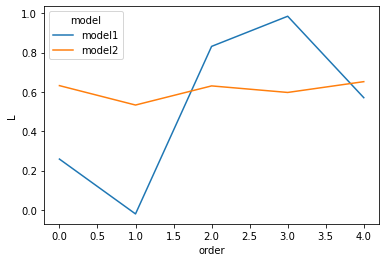

In [8]:
sns.lineplot(x="order", y="L", hue="model", data=df)

In [3]:
df.columns[1:]

,L,RNG,model
0,0.258700,0.589696,model1
1,-0.020000,0.602678,model1
2,0.831294,0.602783,model1
3,0.984428,0.598644,model1
4,0.570581,0.600389,model1
5,0.631915,0.589627,model2
6,0.533225,0.587665,model2
7,0.630487,0.597028,model2
8,0.597202,0.586174,model2
9,0.652064,0.591673,model2


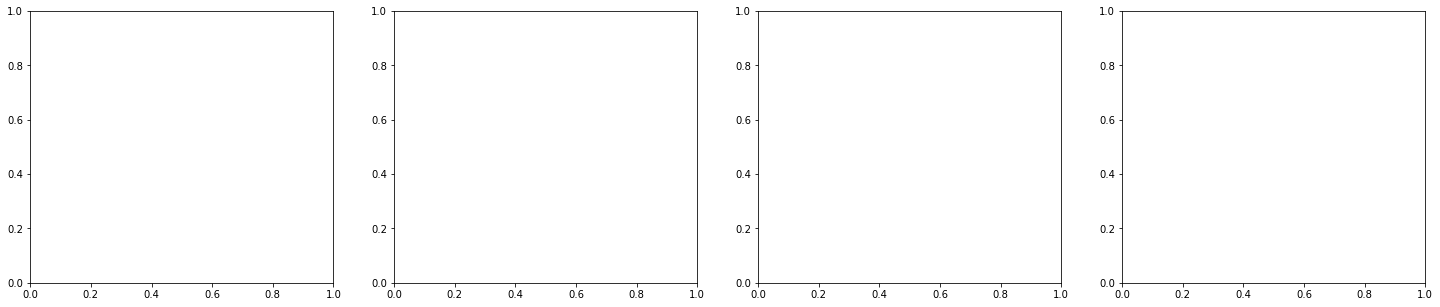

In [13]:
f, axes = plt.subplots(1, 4, figsize=(25, 5))

## 折线图

In [ ]:
f, axes = plt.subplots(1, 4, figsize=(25, 5))
# f.title("heheda")
titles = [
    "ns_prob-target_1d", 
    "s_prob-target_24h", 
    "ns_prob-target_24h", 
    "s_prob-target_1d", 
]
for title, aaa in zip(titles, axes):
    df_ = comp_matrices[title].iloc[:, :-1] 
    aaa.set_title(f"{title}")
    aaa.set(ylim=(0.4, 1.3))
    sns.lineplot(data = df_, ax=aaa)
    aaa.set_xticklabels(list(df_.index),rotation=15)
    
plt.show()